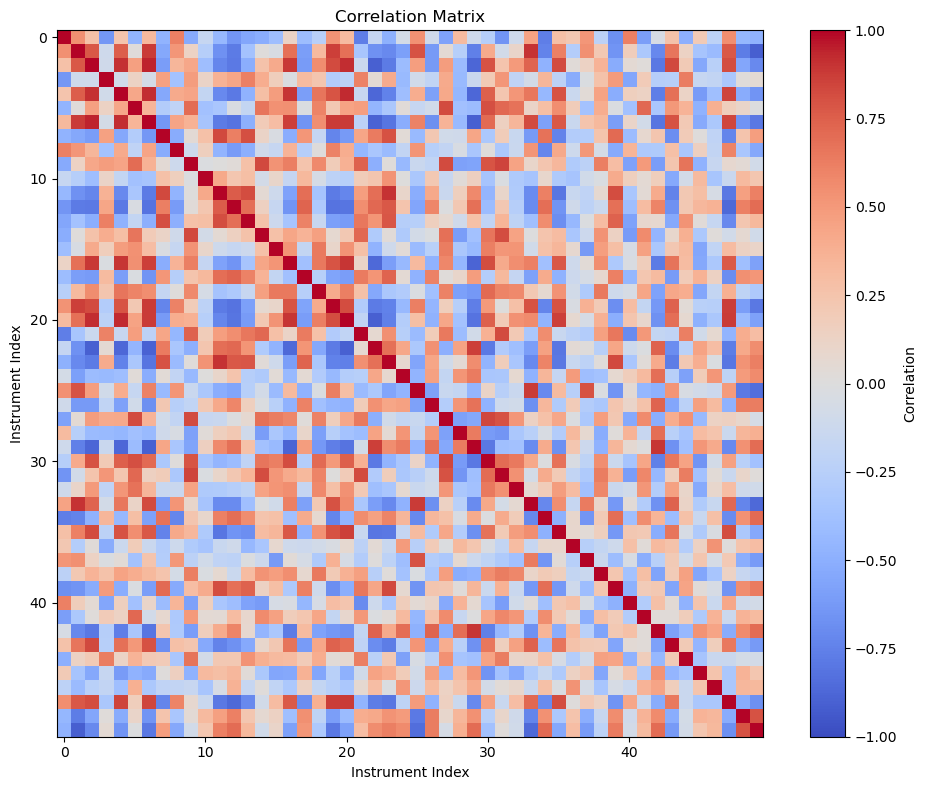

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

# plot correlation matrix

nInst = 50
currentPos = np.zeros(nInst)

df=pd.read_csv("prices.txt", sep='\\s+', header=None, index_col=None)
(nt,nInst) = df.shape
prices = (df.values).T

corr_matrix = np.corrcoef(prices)
plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

plt.title("Correlation Matrix")
plt.xlabel("Instrument Index")
plt.ylabel("Instrument Index")
plt.colorbar(im, label='Correlation')

plt.tight_layout()
plt.show()


Found 48 highly correlated pairs (threshold=0.8):
Instrument 1 and 6 → Corr = 0.879
Instrument 1 and 19 → Corr = 0.865
Instrument 1 and 33 → Corr = 0.899
Instrument 2 and 4 → Corr = 0.906
Instrument 2 and 6 → Corr = 0.938
Instrument 2 and 16 → Corr = 0.885
Instrument 2 and 19 → Corr = 0.828
Instrument 2 and 20 → Corr = 0.918
Instrument 2 and 35 → Corr = 0.821
Instrument 2 and 43 → Corr = 0.830
Instrument 2 and 47 → Corr = 0.816
Instrument 4 and 6 → Corr = 0.918
Instrument 4 and 16 → Corr = 0.897
Instrument 4 and 20 → Corr = 0.926
Instrument 4 and 35 → Corr = 0.804
Instrument 4 and 47 → Corr = 0.852
Instrument 5 and 27 → Corr = 0.820
Instrument 5 and 30 → Corr = 0.812
Instrument 6 and 16 → Corr = 0.860
Instrument 6 and 19 → Corr = 0.875
Instrument 6 and 20 → Corr = 0.882
Instrument 6 and 33 → Corr = 0.825
Instrument 6 and 43 → Corr = 0.803
Instrument 6 and 47 → Corr = 0.837
Instrument 7 and 11 → Corr = 0.831
Instrument 7 and 13 → Corr = 0.807
Instrument 9 and 14 → Corr = 0.828
Instrumen

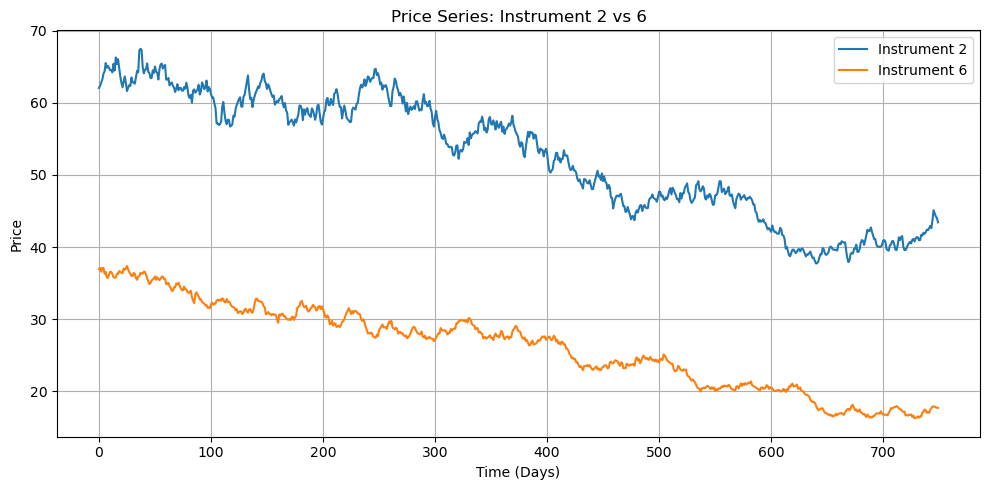

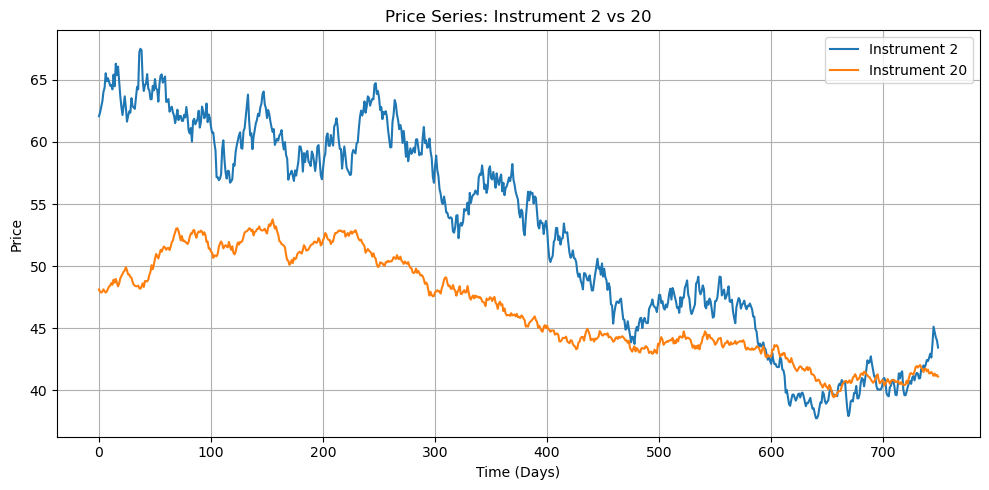

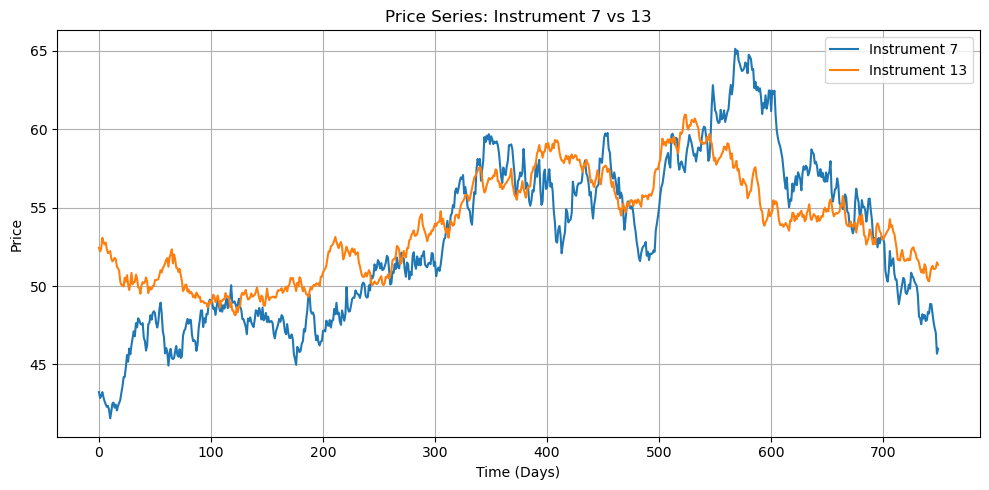

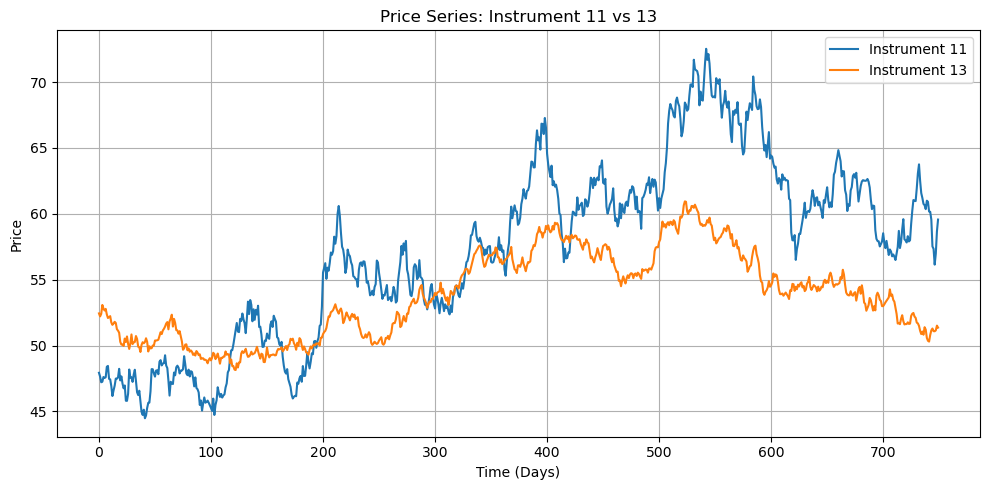

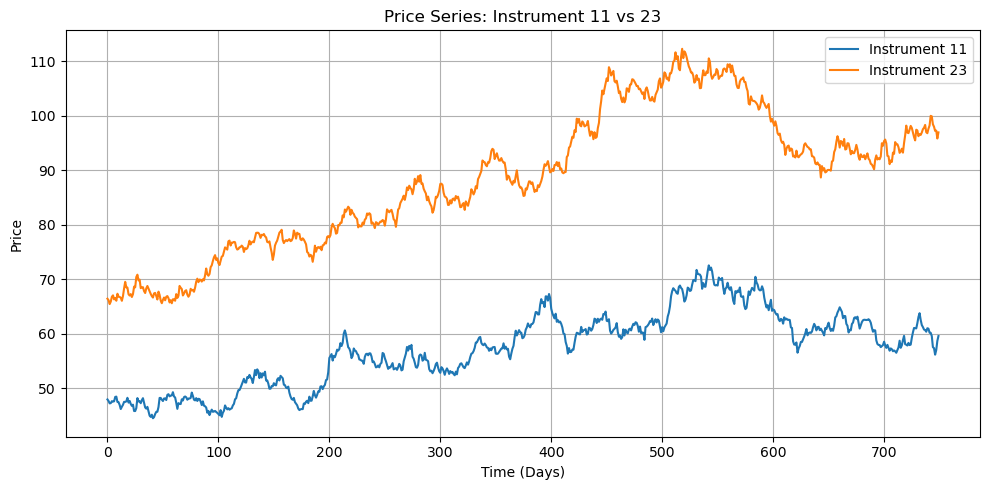

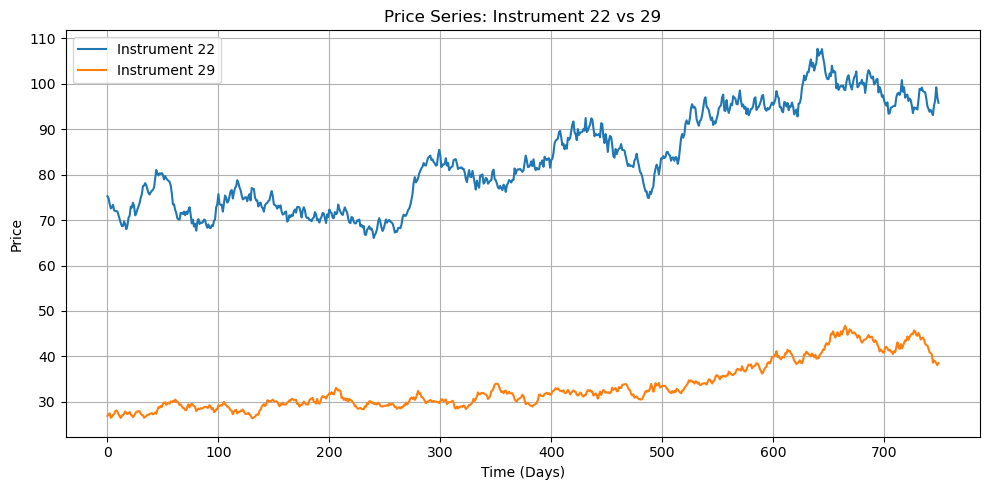

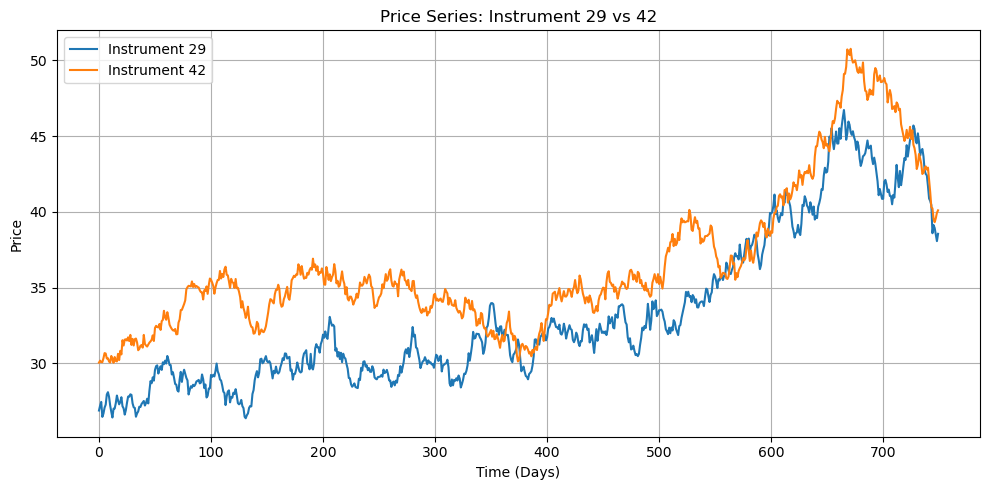

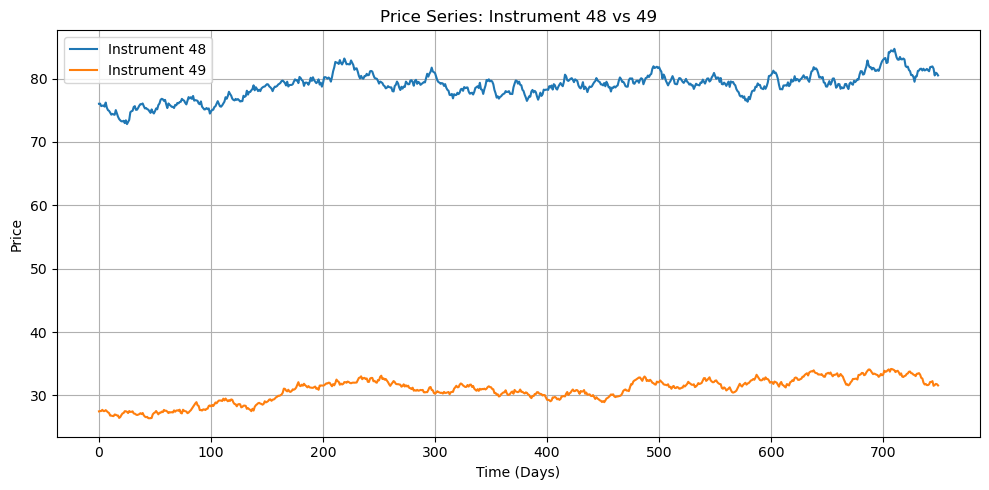

In [2]:
corr_matrix = np.corrcoef(prices)
n = corr_matrix.shape[0]
high_corr_pairs = []

for i in range(n):
    for j in range(i + 1, n):
        if corr_matrix[i, j] >= 0.8:
            high_corr_pairs.append((i, j, corr_matrix[i, j]))
            
print(f"Found {len(high_corr_pairs)} highly correlated pairs (threshold={0.8}):")
for i, j, corr in high_corr_pairs:
    print(f"Instrument {i} and {j} → Corr = {corr:.3f}")

def test_coint(high_corr_pairs, prices):
    coint_pairs = []
    for i, j, corr in high_corr_pairs:
        _, p_value, _ = ts.coint(prices[i], prices[j])
        if p_value < 0.05:
            print(f"Instruments {i} and {j} are cointegrated (p-value = {p_value:.4f})")
            coint_pairs.append((i, j, corr))
    return coint_pairs

coint_pairs = test_coint(high_corr_pairs, prices)
for i, j, corr in coint_pairs:
    plt.figure(figsize=(10, 5))
    plt.plot(prices[i], label=f"Instrument {i}")
    plt.plot(prices[j], label=f"Instrument {j}")
    plt.title(f"Price Series: Instrument {i} vs {j}")
    plt.xlabel("Time (Days)")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

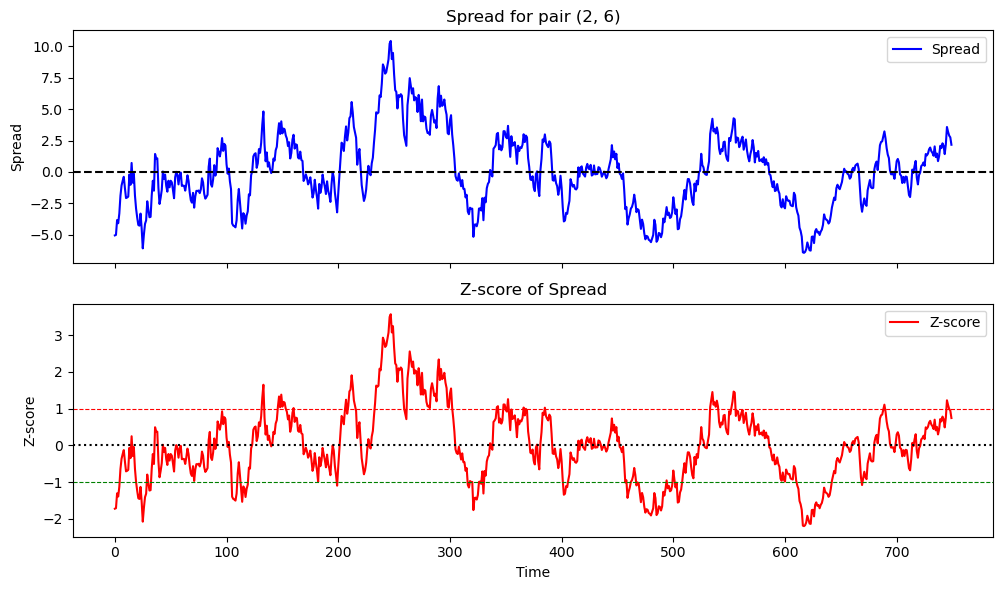

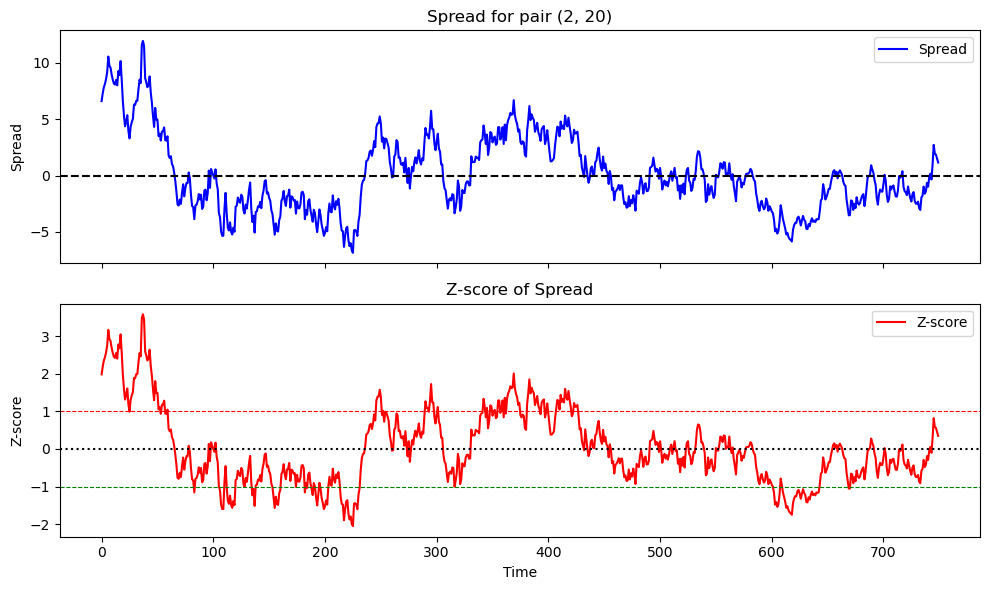

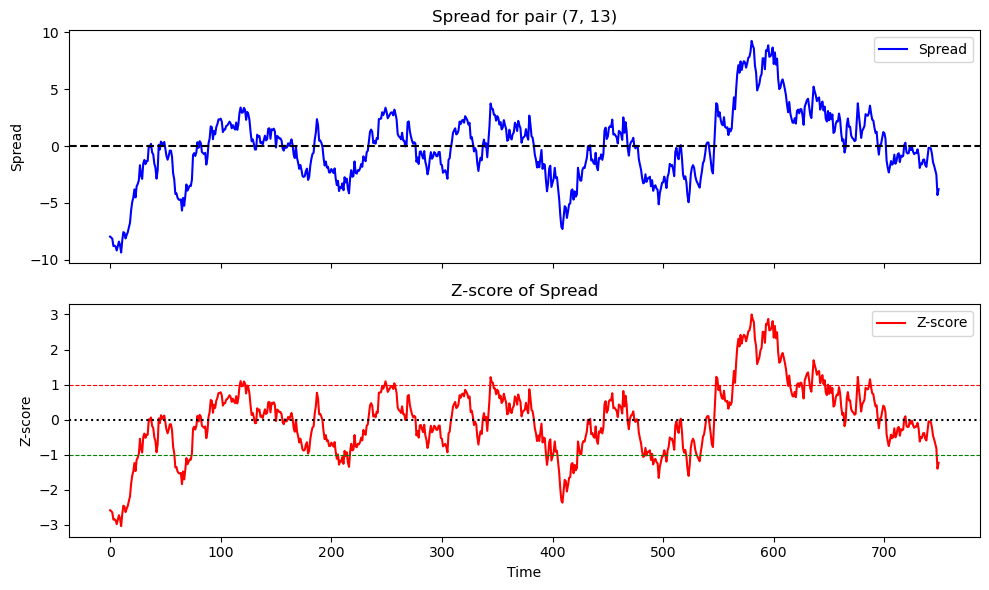

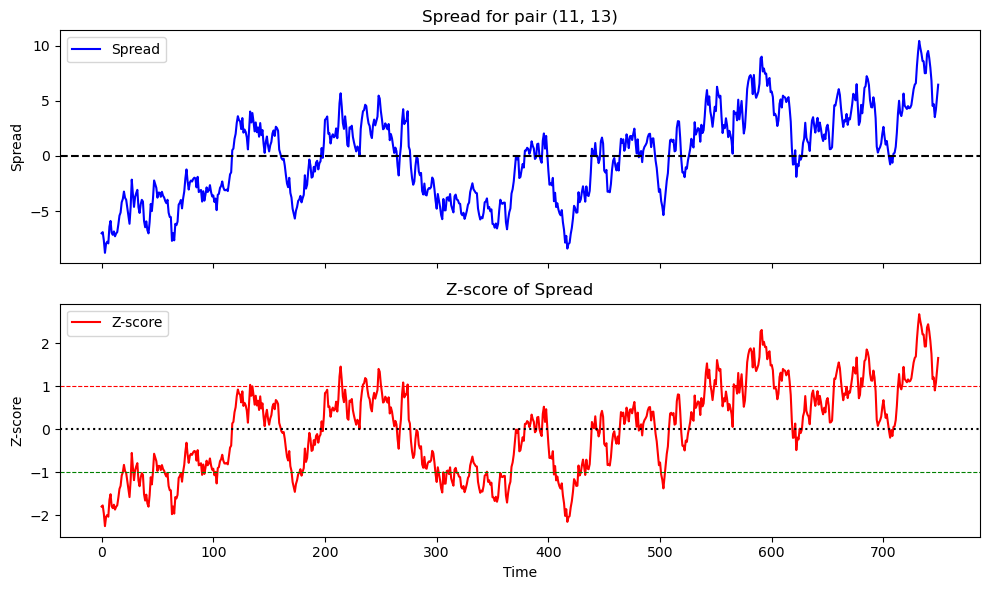

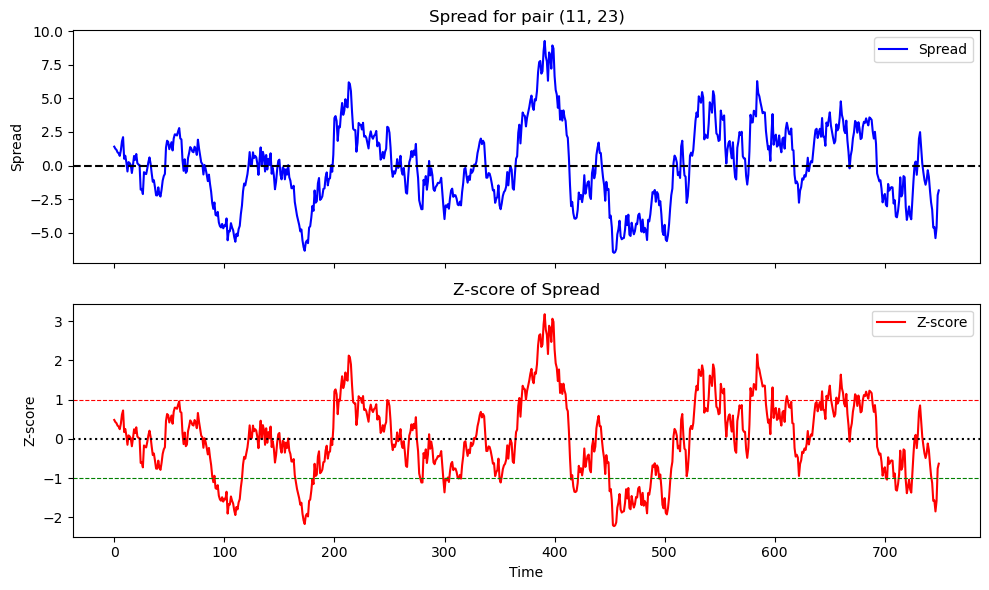

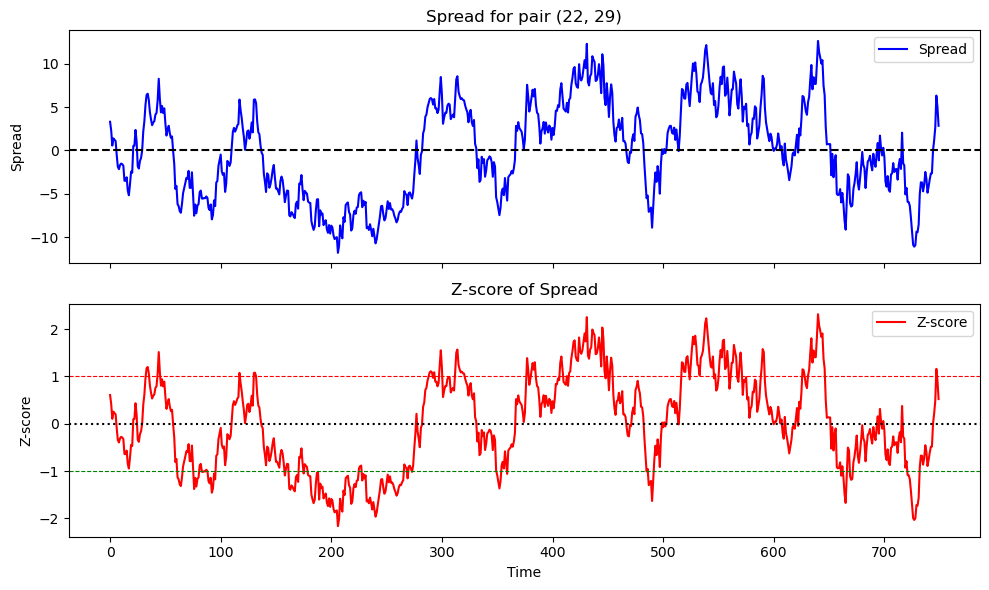

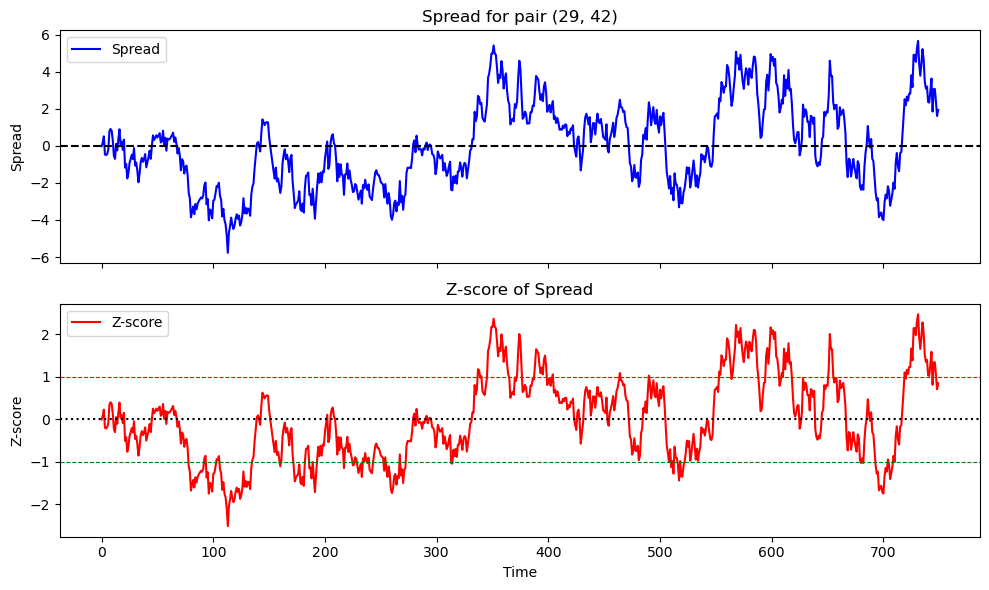

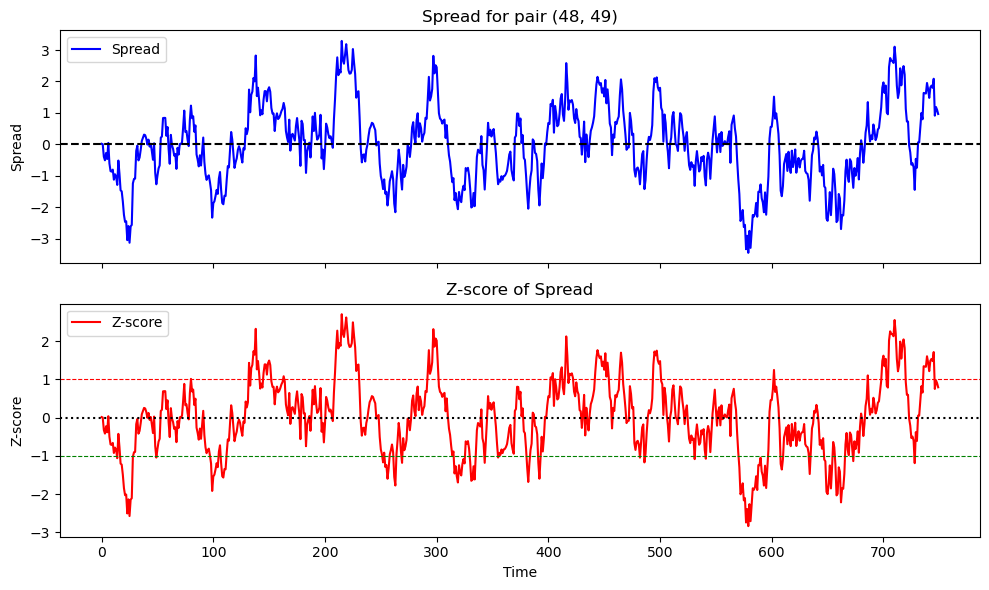

In [3]:
#TODO: plot spreads of coint pairs
def plot_spreads(high_corr_pairs, prices):
    for i, j, _ in high_corr_pairs:
        inst1 = prices[i]
        inst2 = prices[j]

        # Run OLS: inst1 ~ alpha + beta * inst2
        inst2_const = sm.add_constant(inst2)
        model = sm.OLS(inst1, inst2_const).fit()
        alpha, beta = model.params

        # Calculate spread and z-score
        spread = inst1 - (alpha + beta * inst2)
        mean = np.mean(spread)
        std = np.std(spread)
        zscore = (spread - mean) / std

        # Plot in two subplots
        fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

        # Spread plot
        axs[0].plot(spread, color='blue', label='Spread')
        axs[0].axhline(0, color='black', linestyle='--')
        axs[0].set_title(f"Spread for pair ({i}, {j})")
        axs[0].set_ylabel("Spread")
        axs[0].legend()

        # Z-score plot
        axs[1].plot(zscore, color='red', label='Z-score')
        axs[1].axhline(0, color='black', linestyle=':')
        axs[1].axhline(1, color='red', linestyle='--', linewidth=0.8)
        axs[1].axhline(-1, color='green', linestyle='--', linewidth=0.8)
        axs[1].set_title("Z-score of Spread")
        axs[1].set_ylabel("Z-score")
        axs[1].set_xlabel("Time")
        axs[1].legend()

        plt.tight_layout()
        plt.show()
        
plot_spreads(coint_pairs, prices)

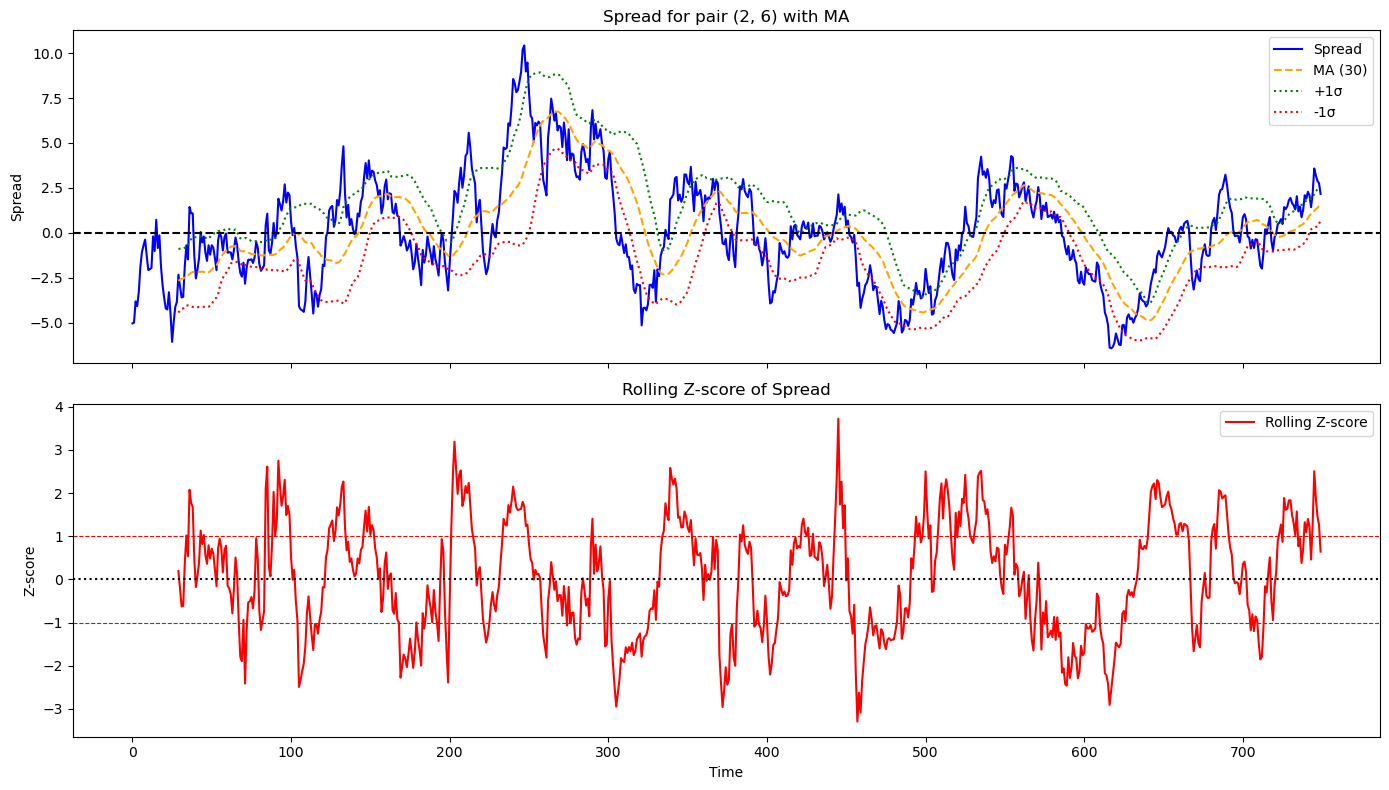

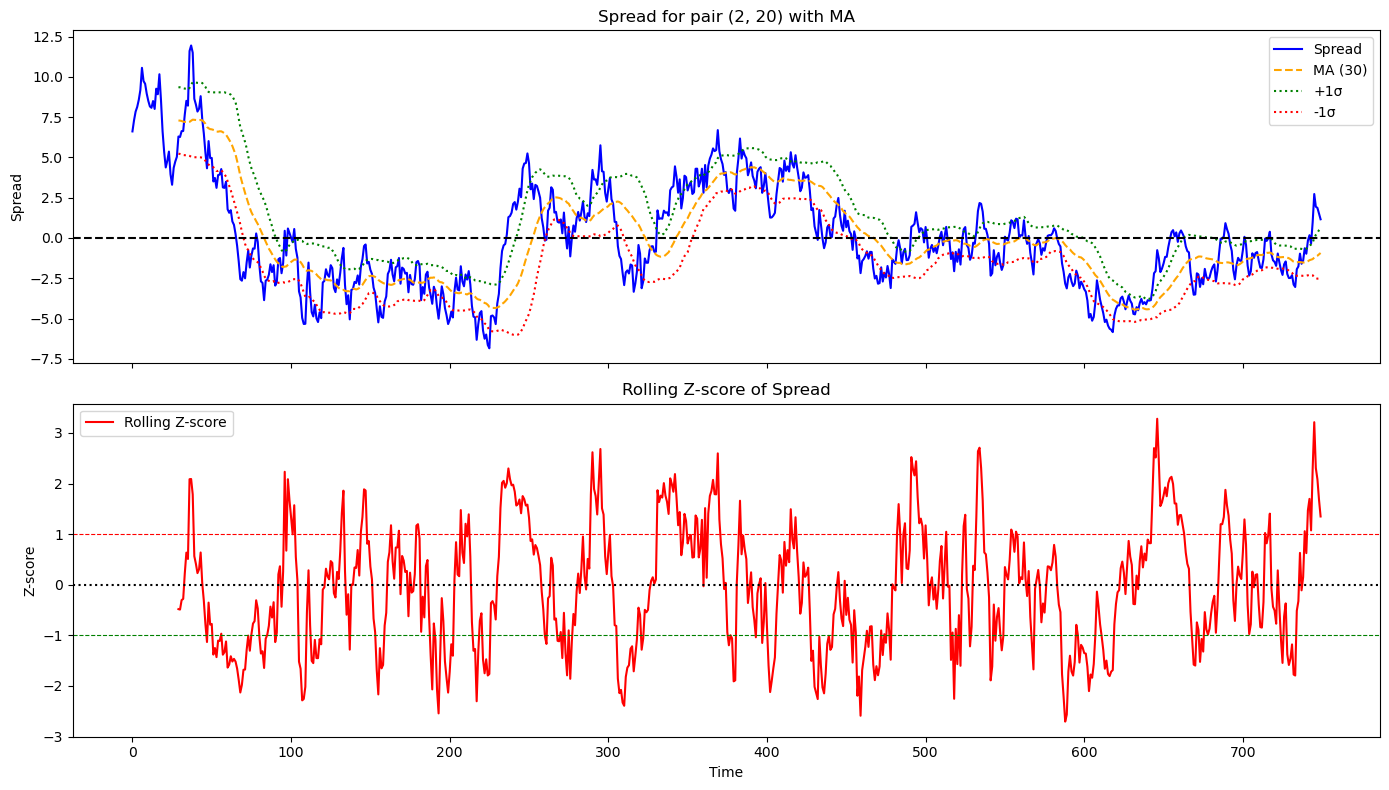

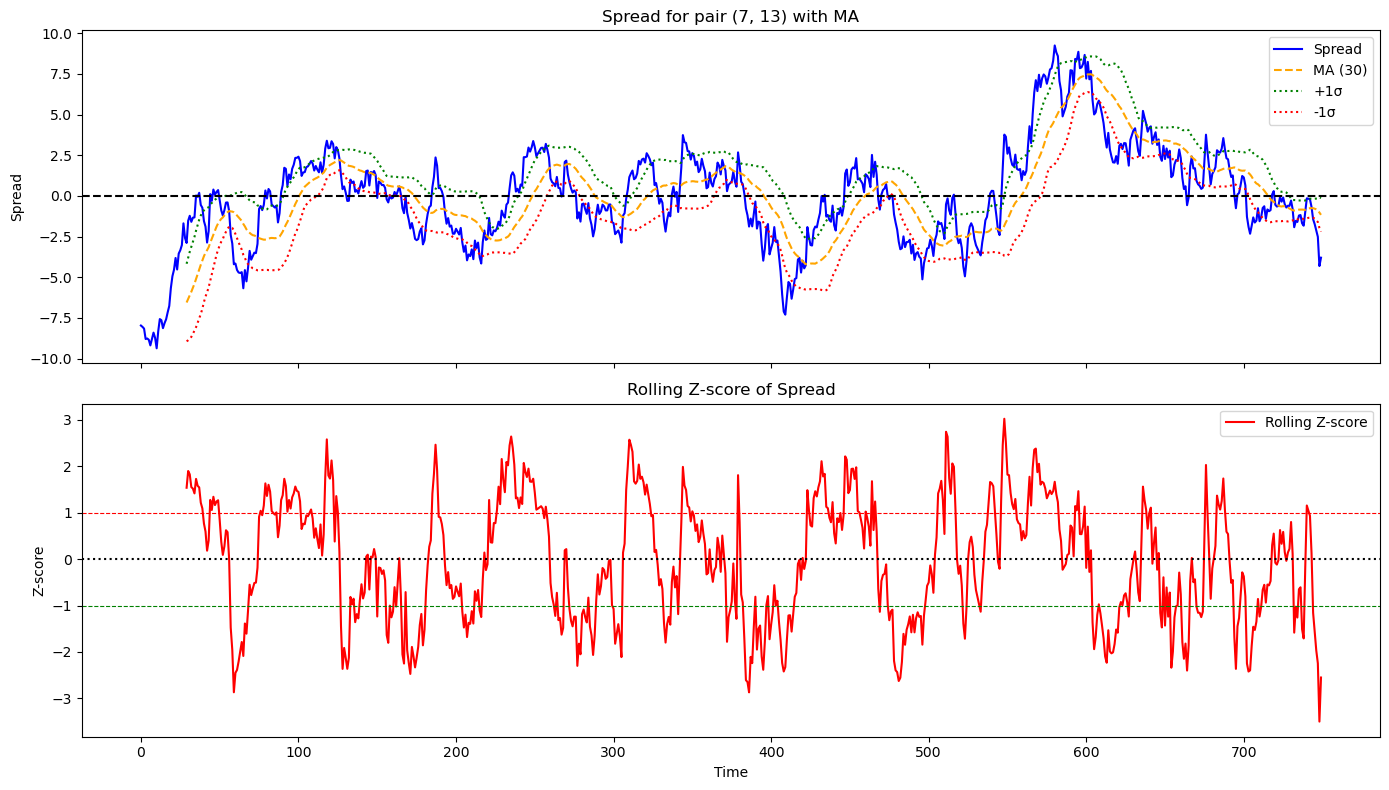

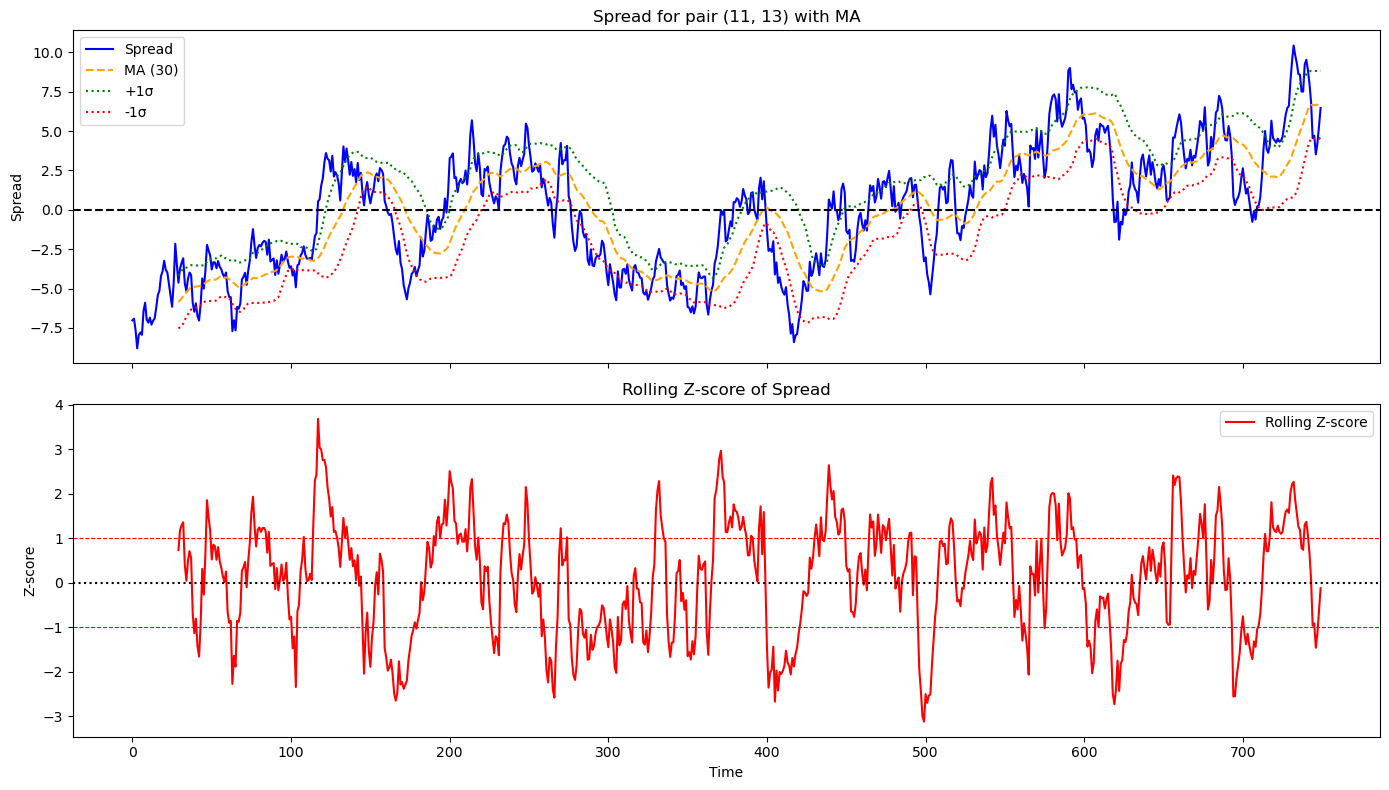

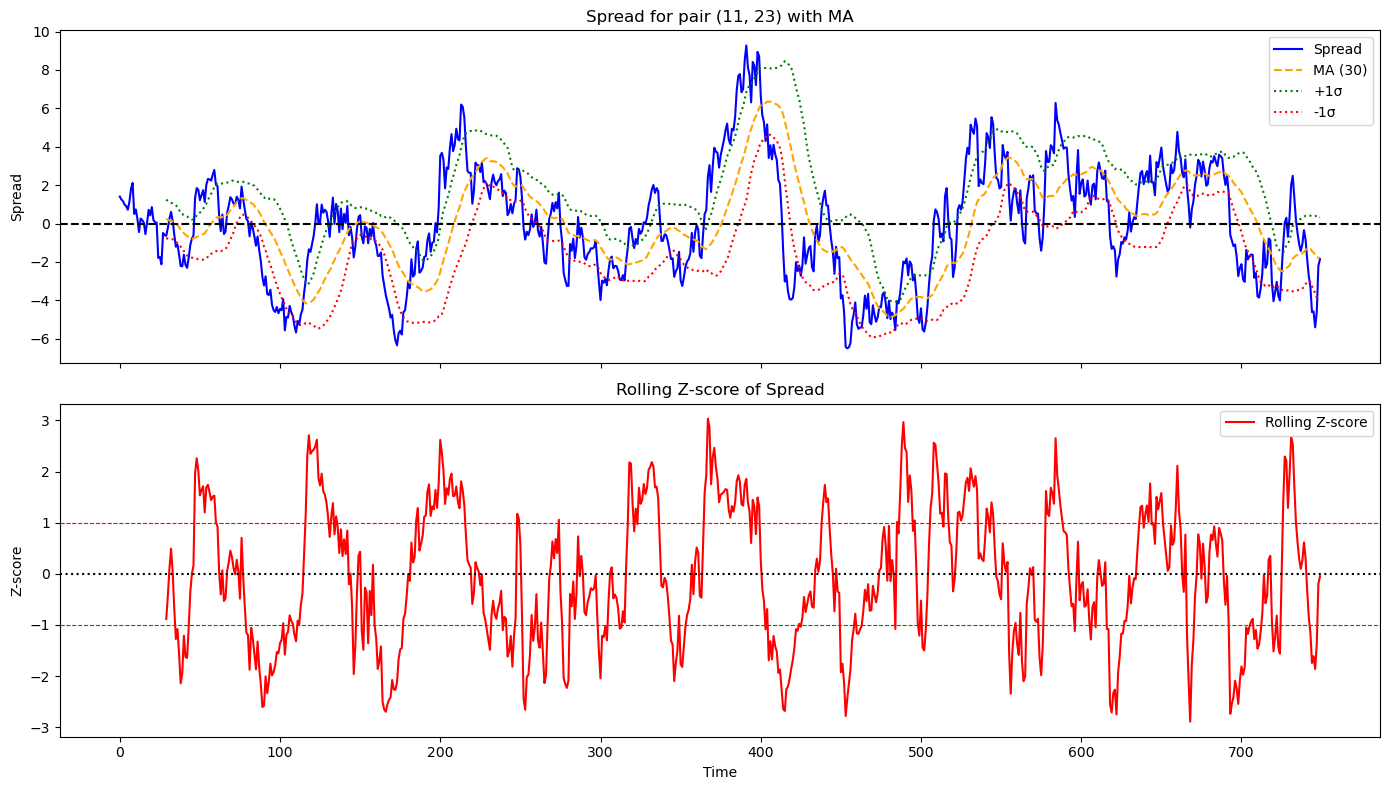

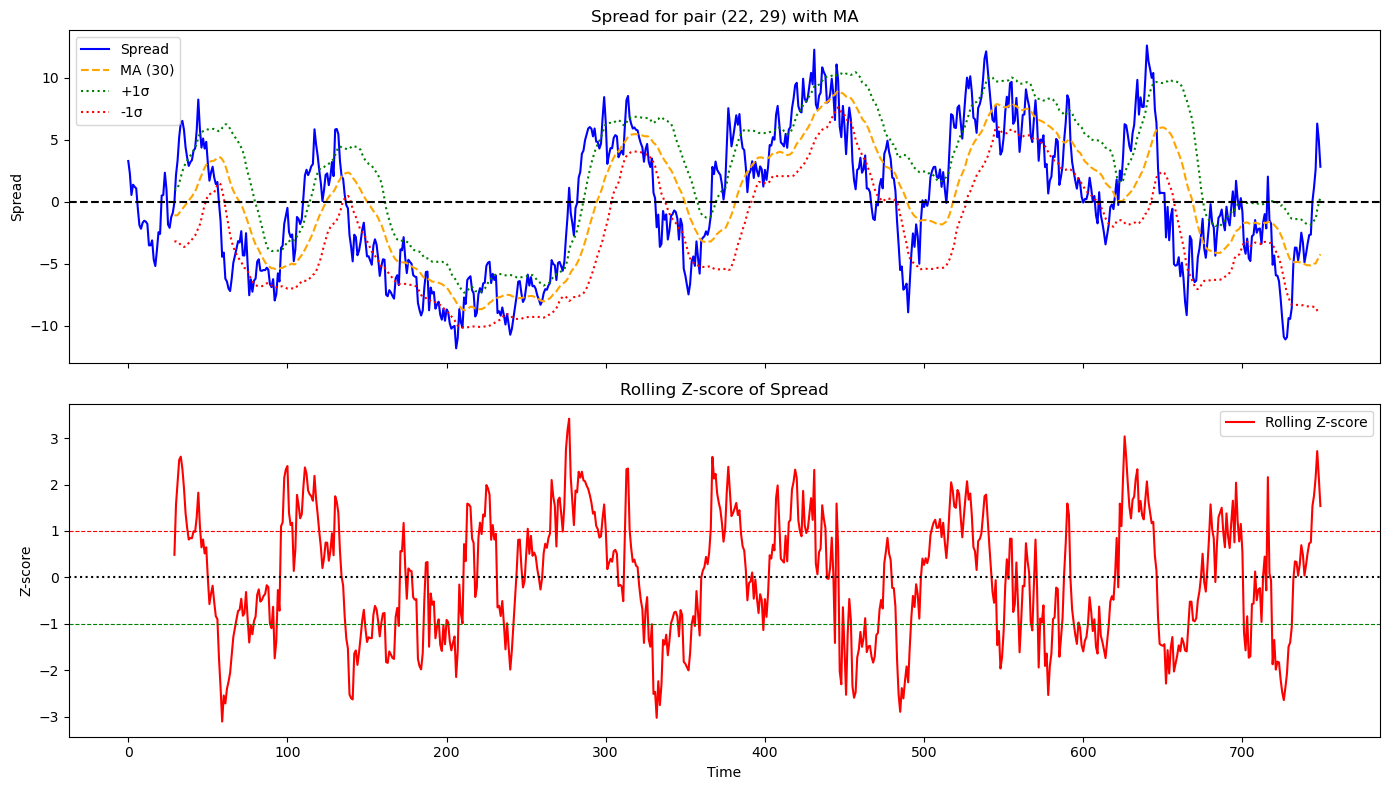

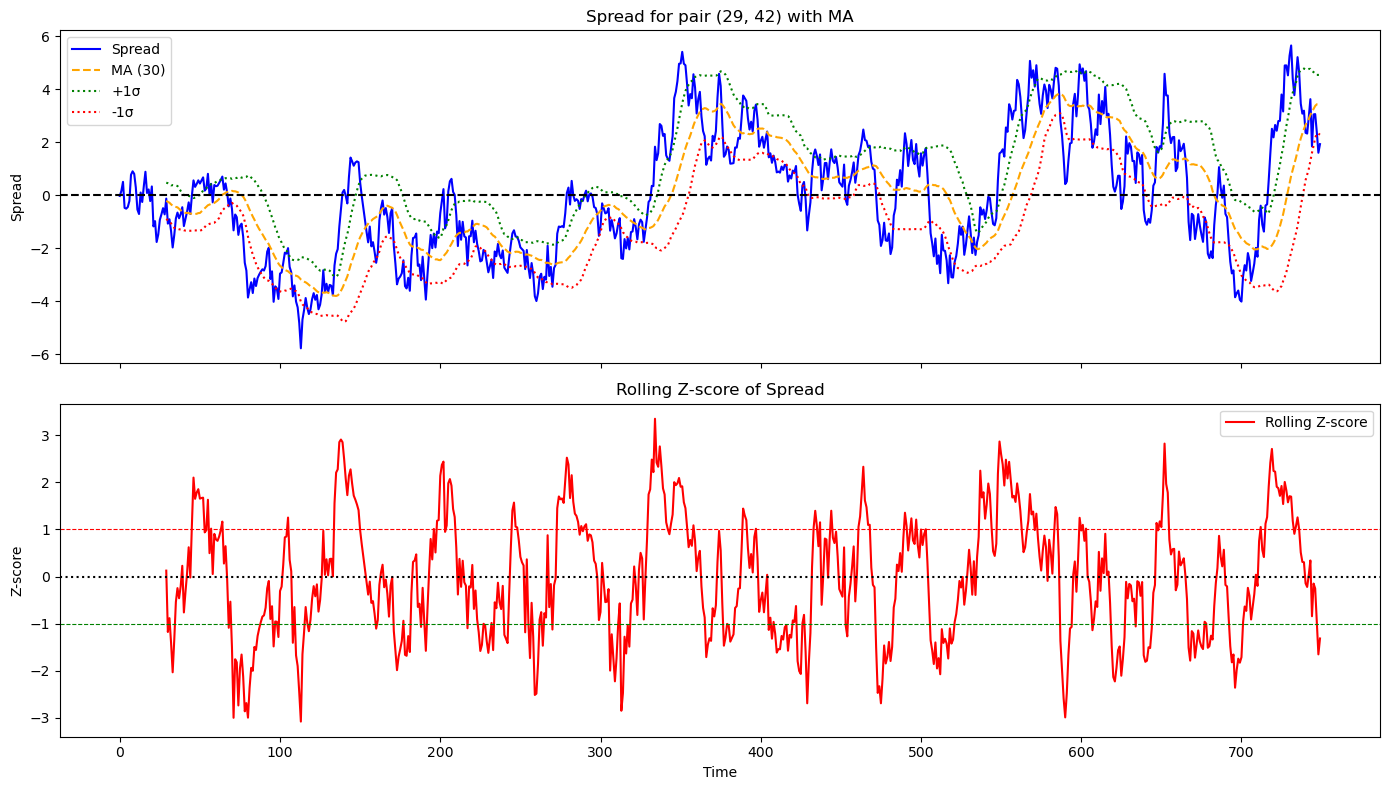

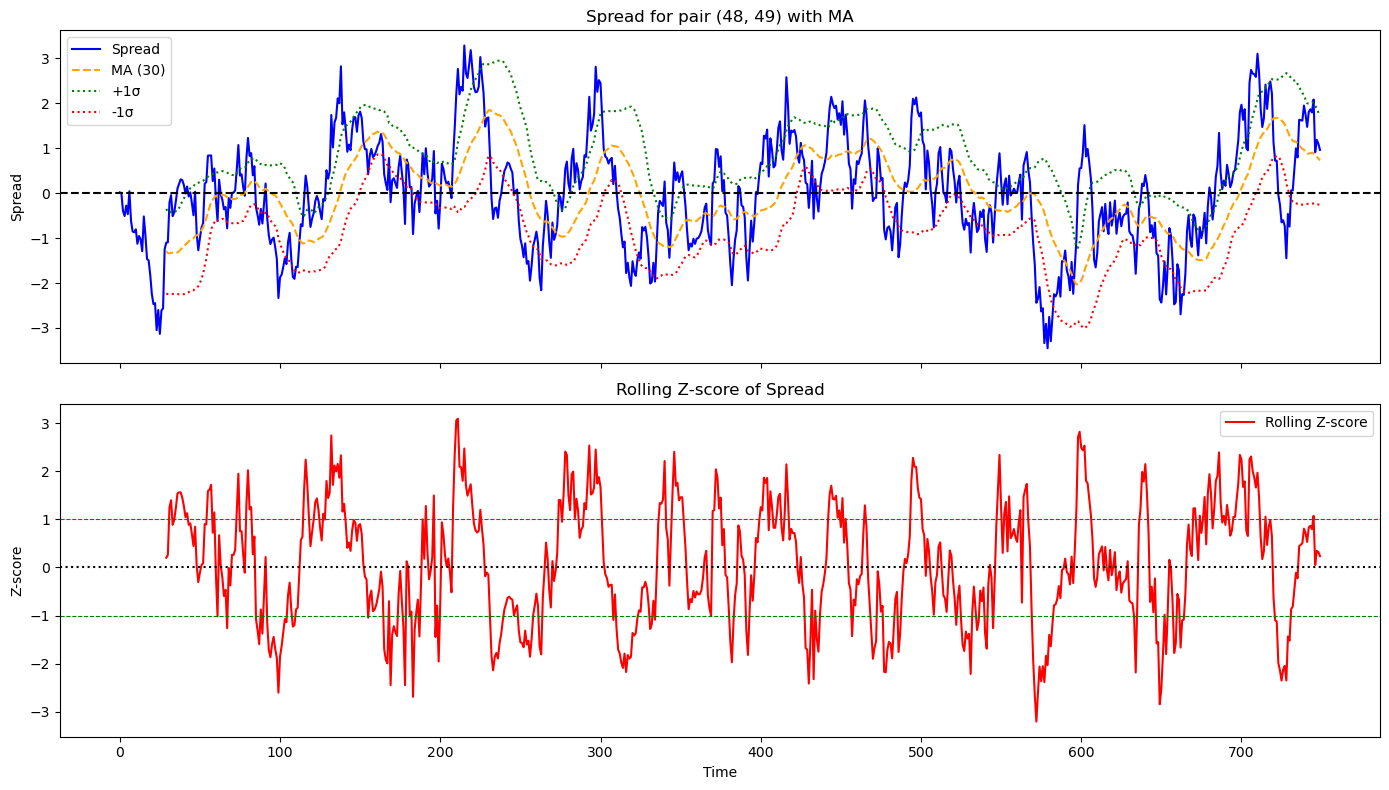

In [4]:
window = 30
def plot_moving_averages(high_corr_pairs, prices):
    for i, j, _ in high_corr_pairs:
        inst1 = prices[i]
        inst2 = prices[j]

        # Run OLS: inst1 ~ alpha + beta * inst2
        inst2_const = sm.add_constant(inst2)
        model = sm.OLS(inst1, inst2_const).fit()
        alpha, beta = model.params

        # Calculate spread and z-score
        spread = inst1 - (alpha + beta * inst2)
        spread_series = pd.Series(spread)

        # Rolling statistics
        rolling_mean = spread_series.rolling(window=window).mean()
        rolling_std = spread_series.rolling(window=window).std()
        zscore = (spread_series - rolling_mean) / rolling_std
        
        # Plot in two subplots
        fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

        # --- Spread with moving average and ±1 std ---
        axs[0].plot(spread_series, color='blue', label='Spread')
        axs[0].plot(rolling_mean, color='orange', linestyle='--', label=f"MA ({window})")
        axs[0].plot(rolling_mean + rolling_std, color='green', linestyle=':', label='+1σ')
        axs[0].plot(rolling_mean - rolling_std, color='red', linestyle=':', label='-1σ')
        axs[0].axhline(0, color='black', linestyle='--')
        axs[0].set_title(f"Spread for pair ({i}, {j}) with MA")
        axs[0].set_ylabel("Spread")
        axs[0].legend()

        # --- Z-score subplot ---
        axs[1].plot(zscore, color='red', label='Rolling Z-score')
        axs[1].axhline(0, color='black', linestyle=':')
        axs[1].axhline(1, color='red', linestyle='--', linewidth=0.8)
        axs[1].axhline(-1, color='green', linestyle='--', linewidth=0.8)
        axs[1].set_title("Rolling Z-score of Spread")
        axs[1].set_ylabel("Z-score")
        axs[1].set_xlabel("Time")
        axs[1].legend()

        plt.tight_layout()
        plt.show()
        
plot_moving_averages(coint_pairs, prices)

50


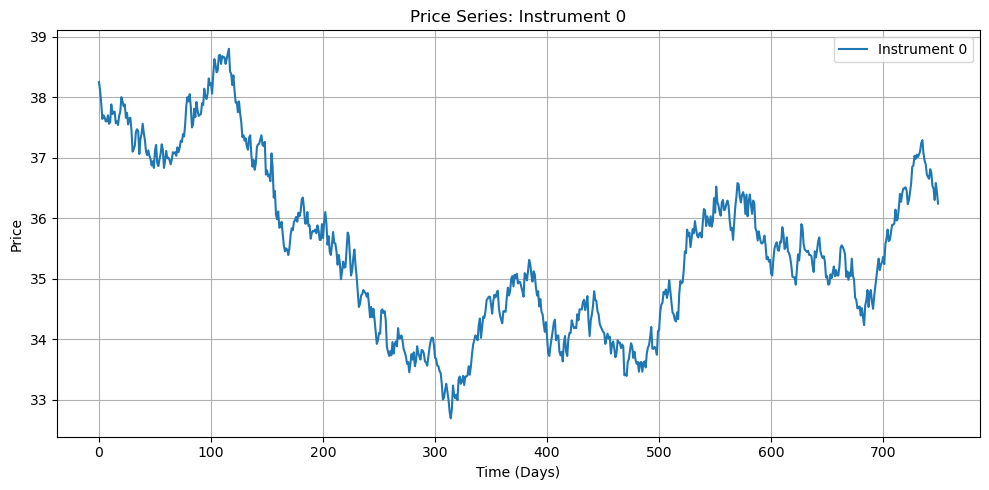

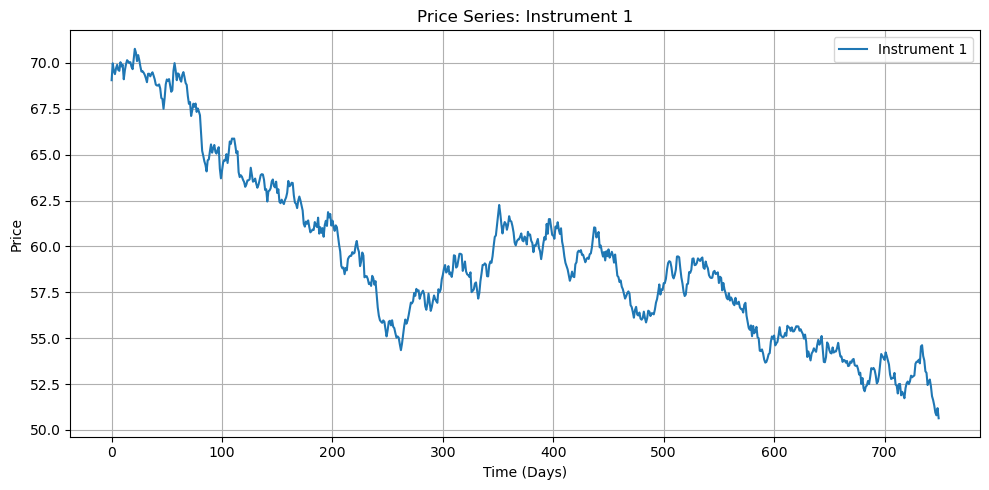

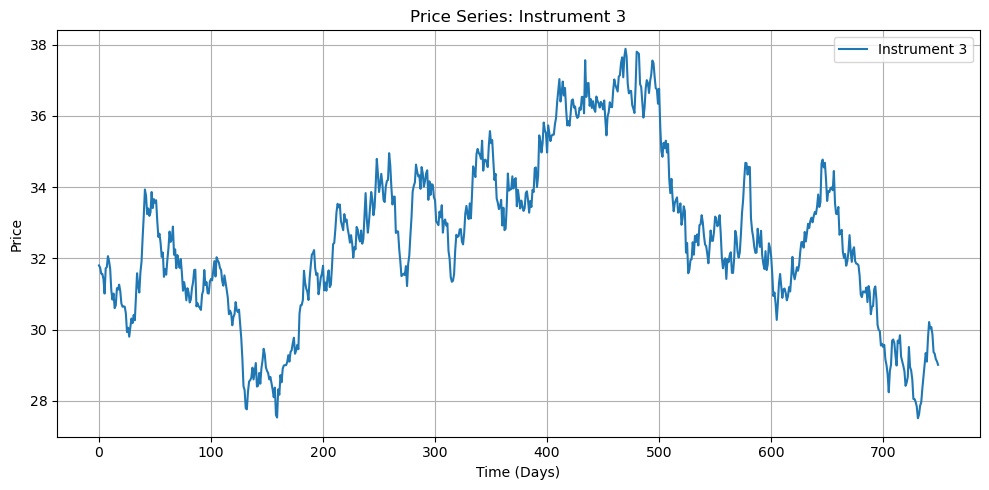

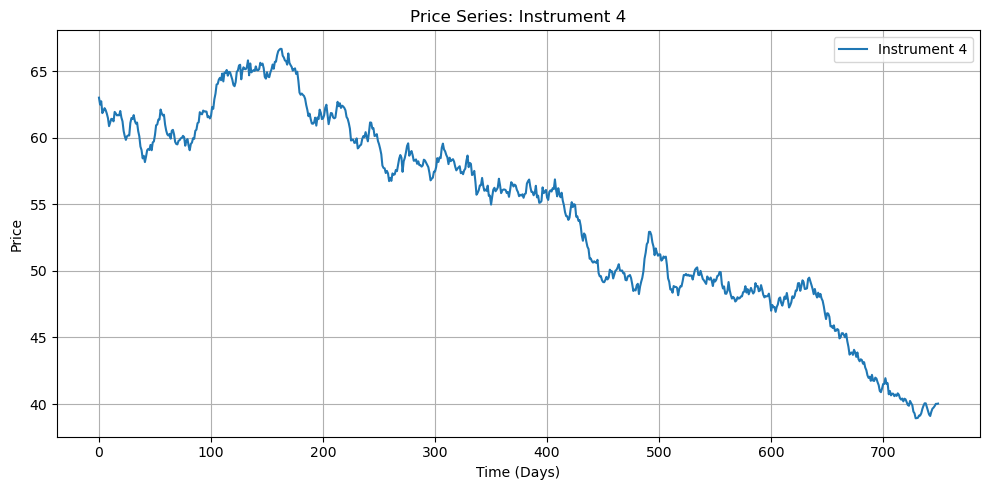

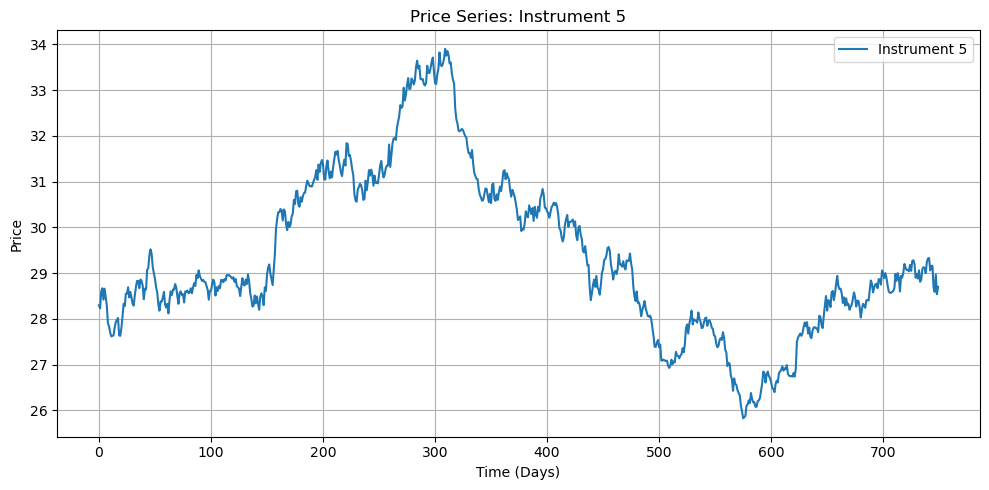

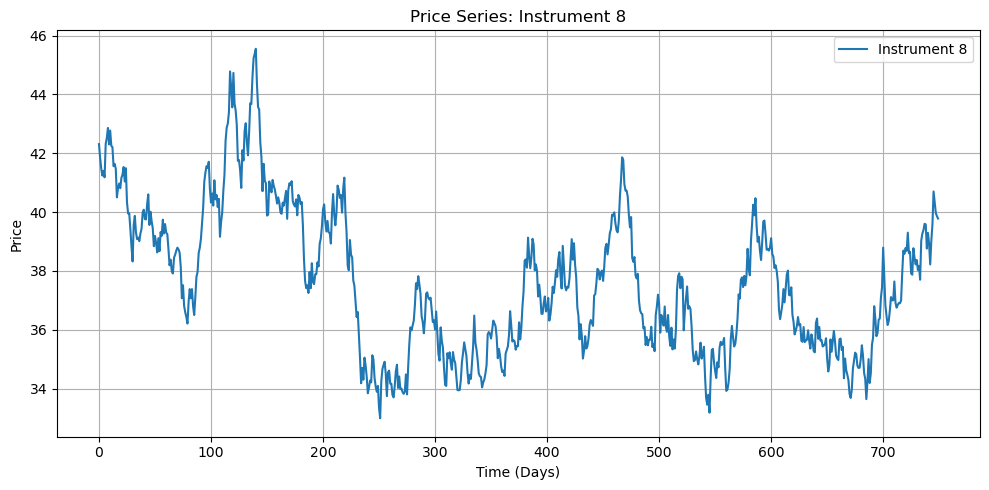

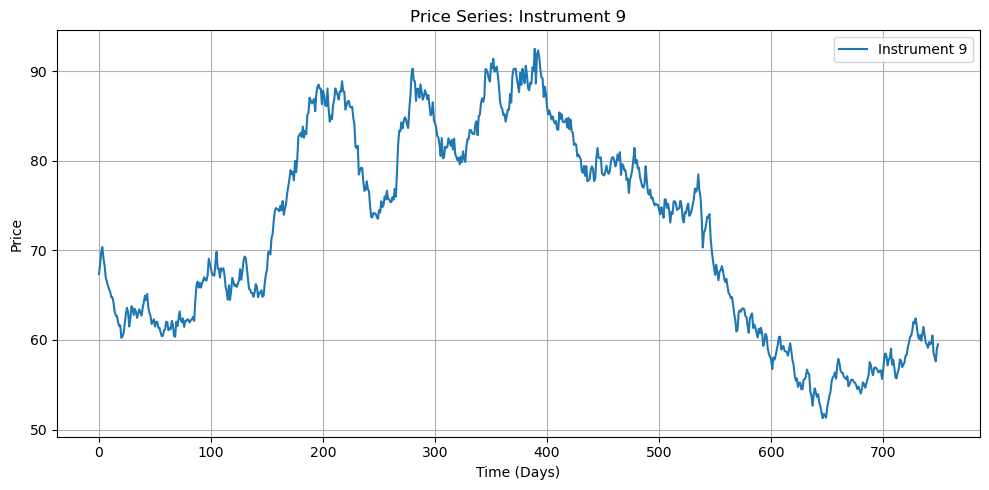

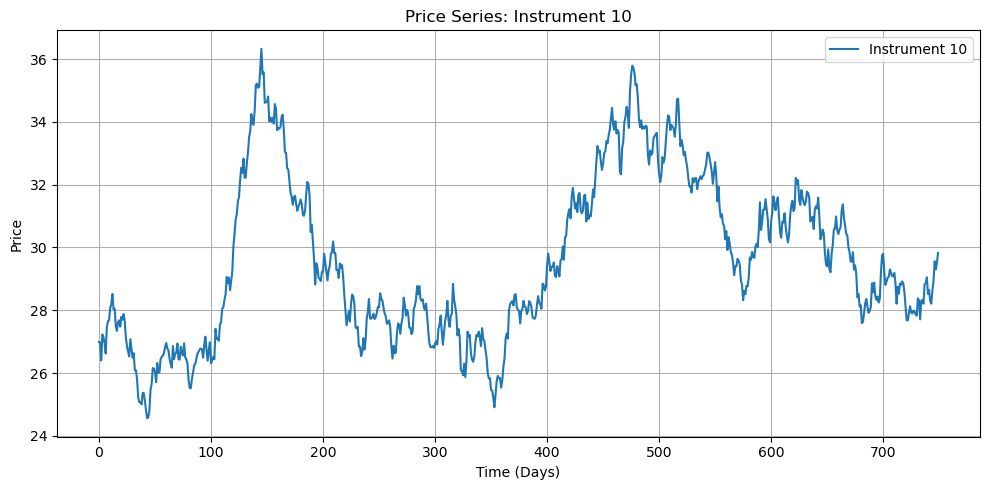

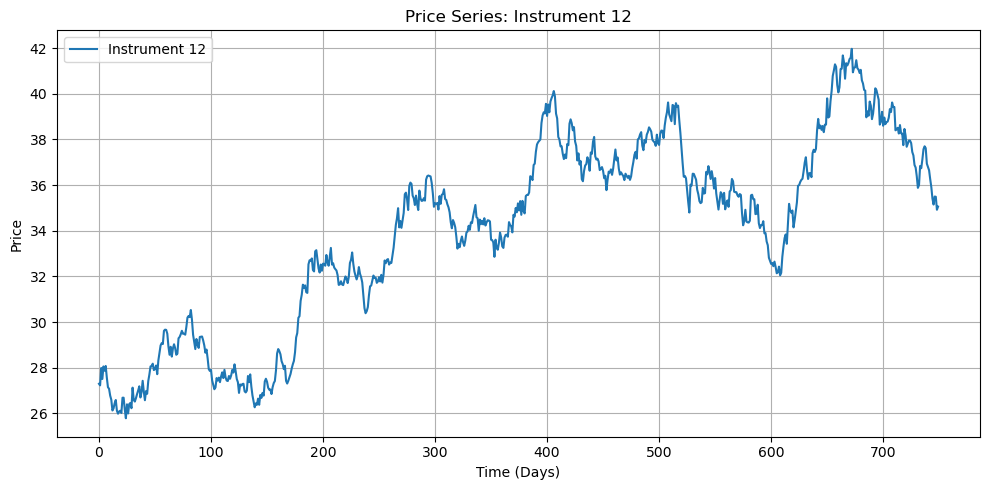

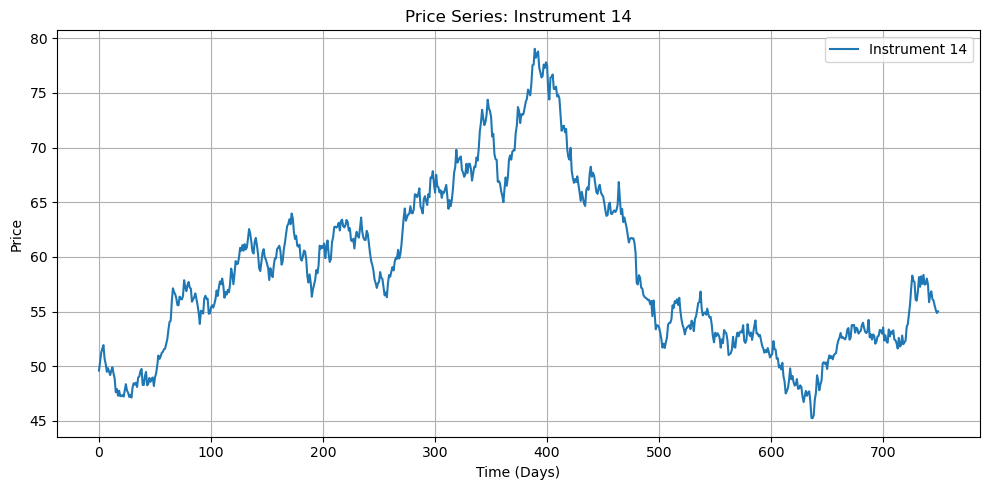

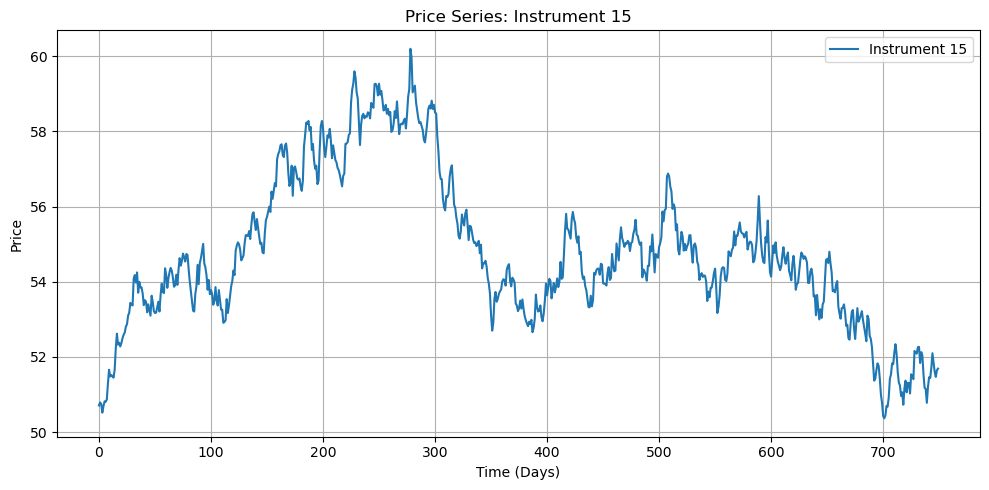

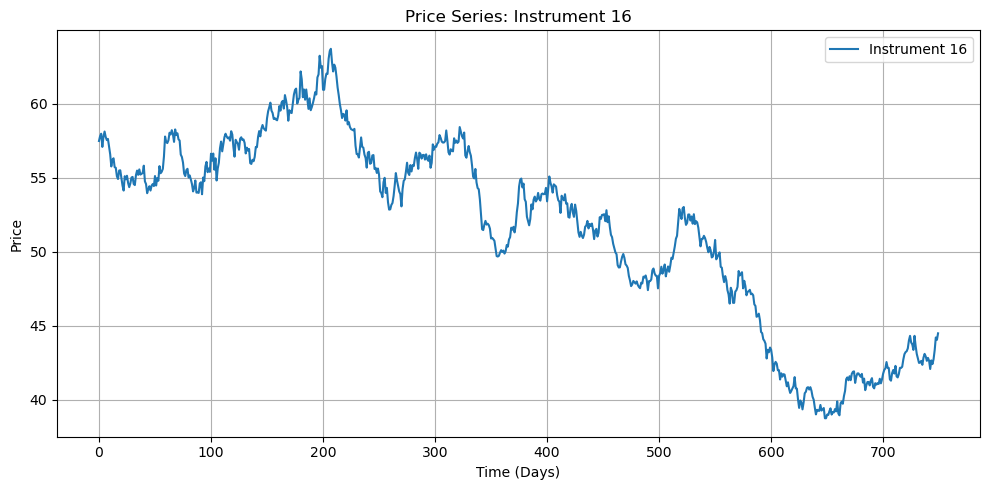

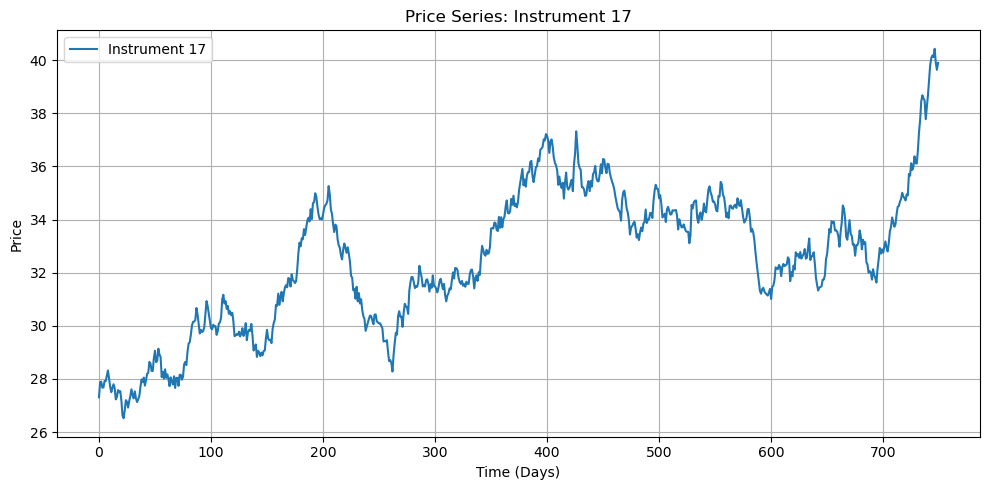

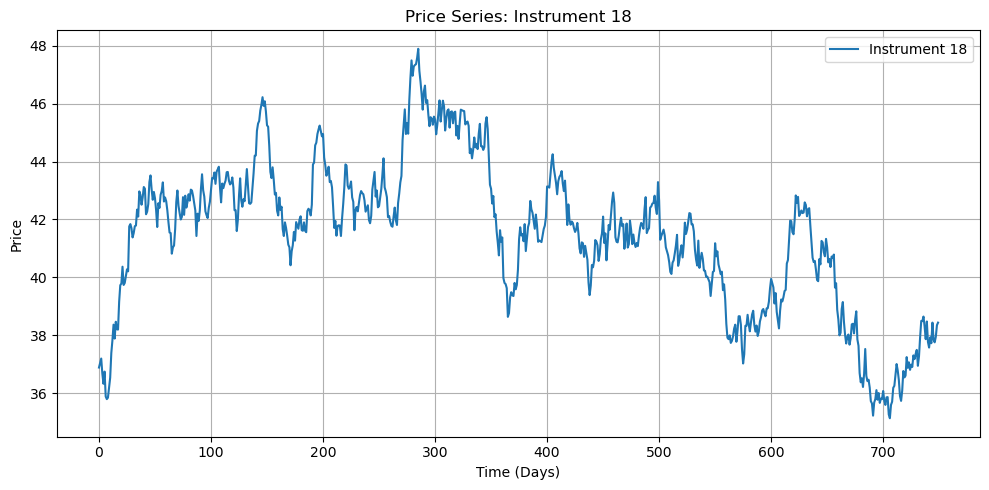

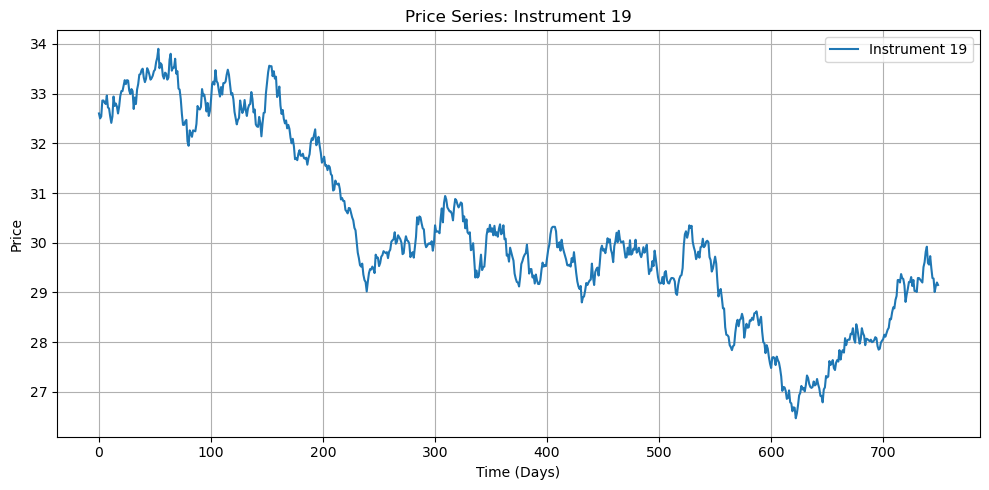

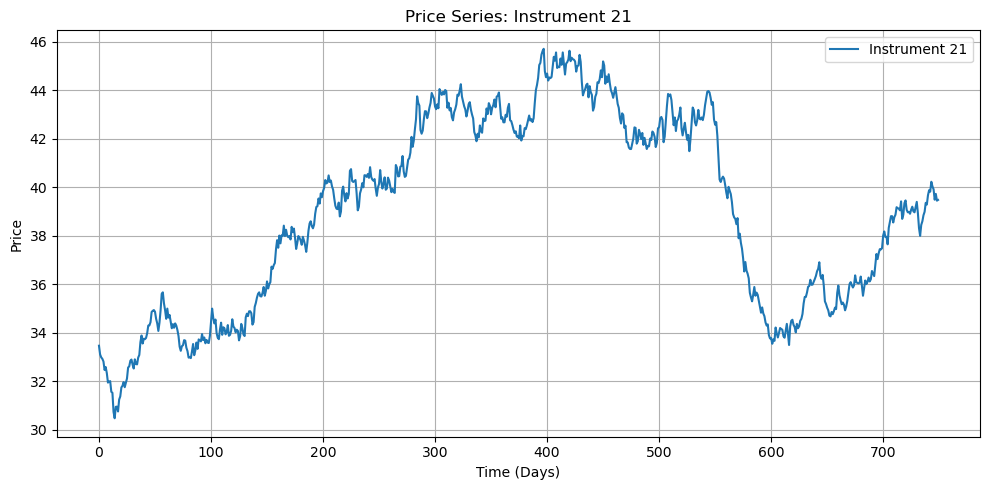

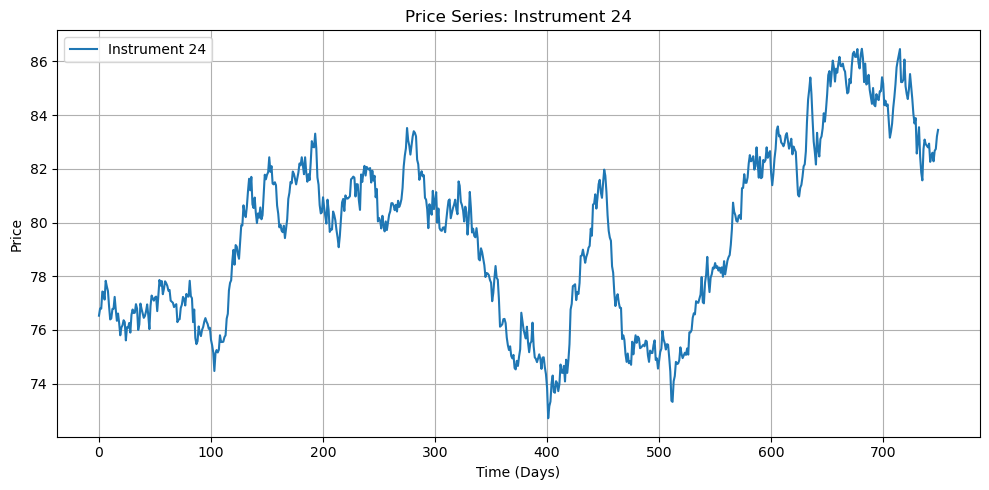

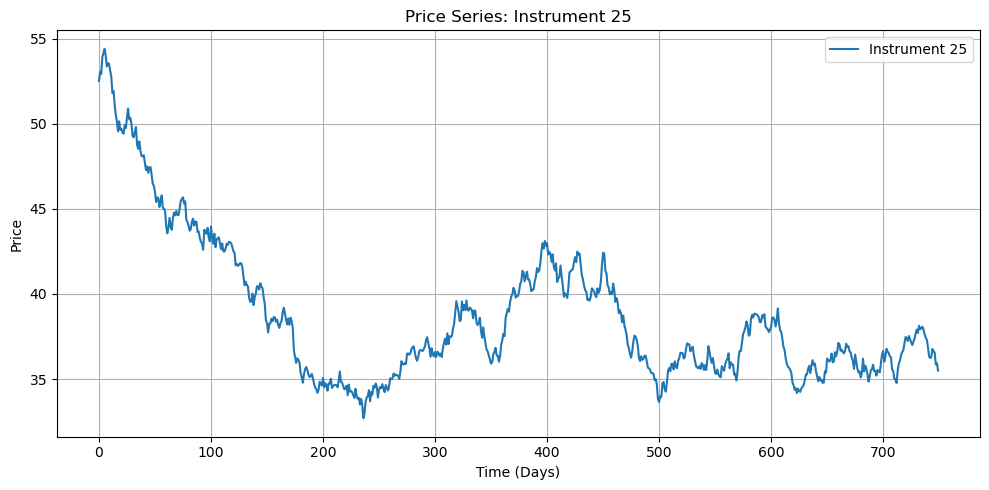

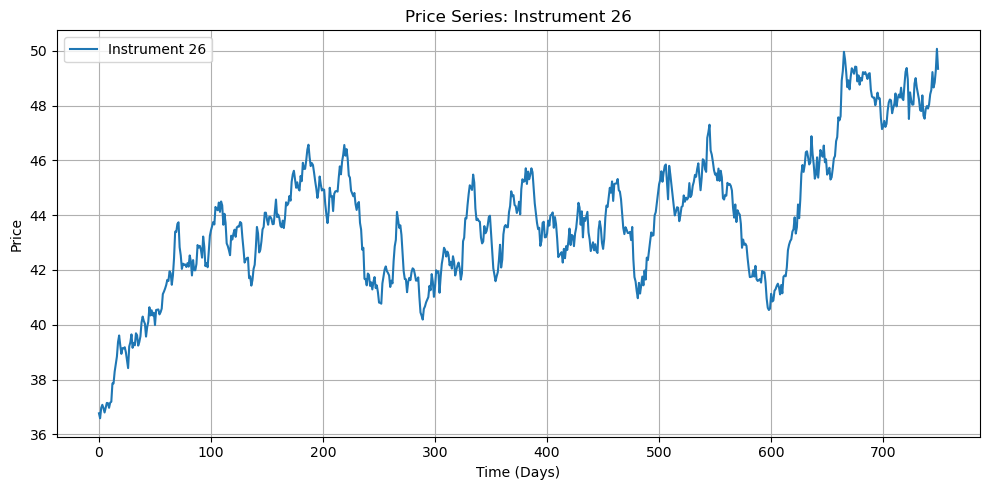

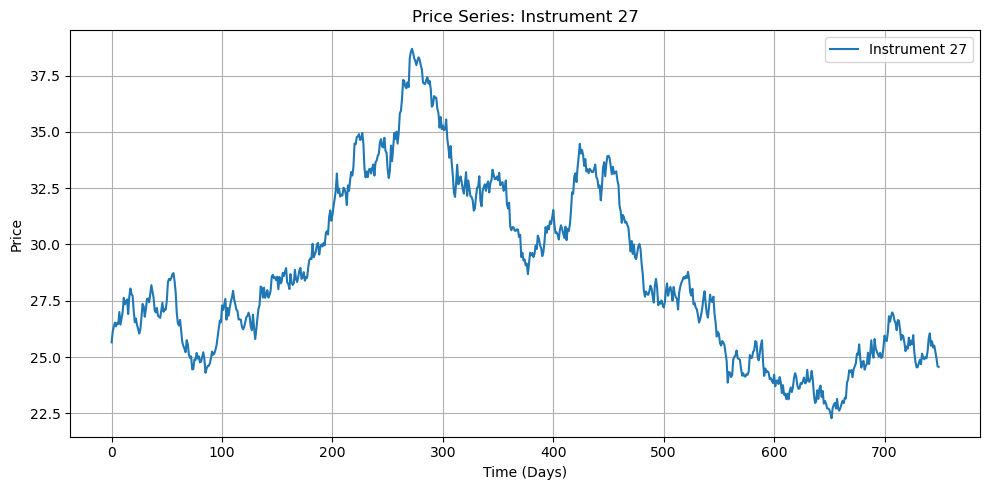

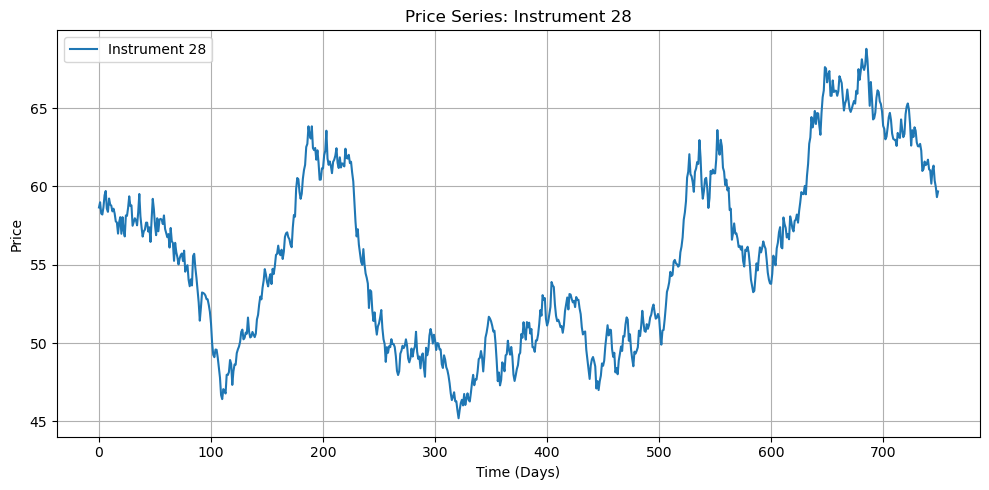

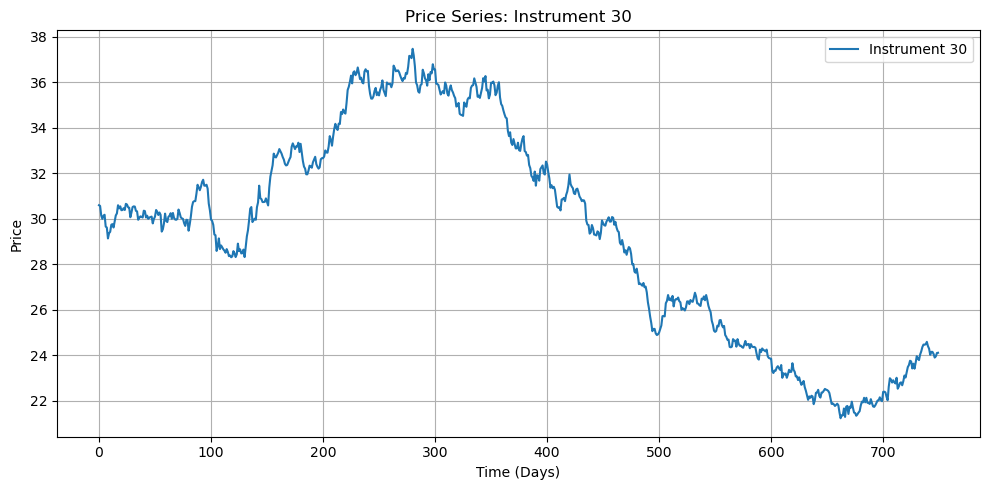

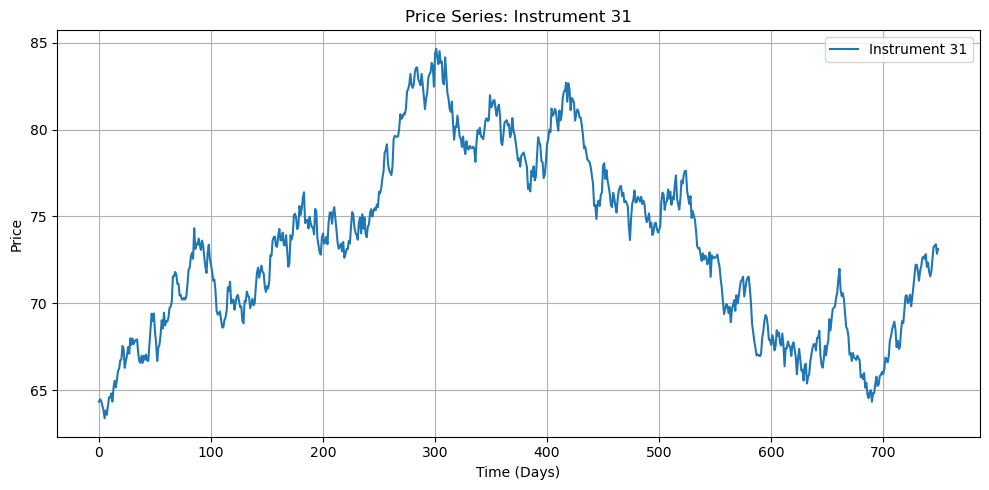

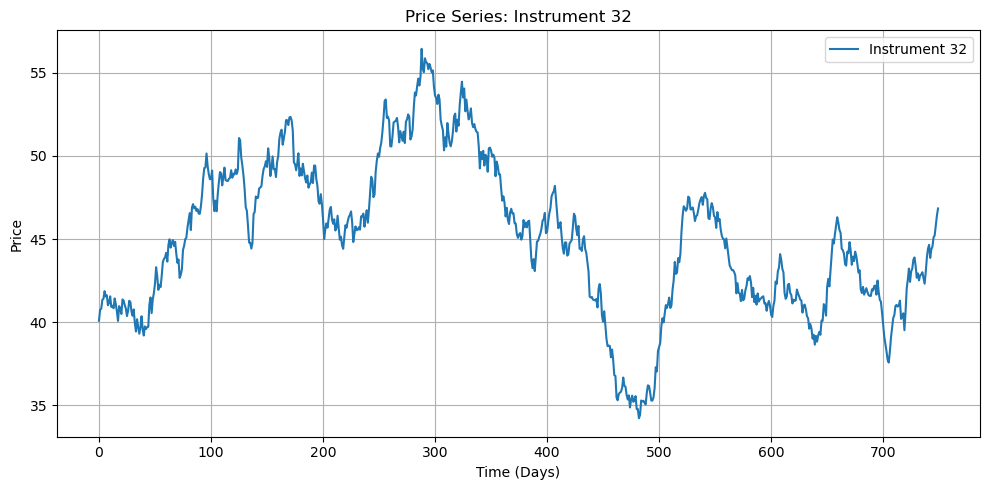

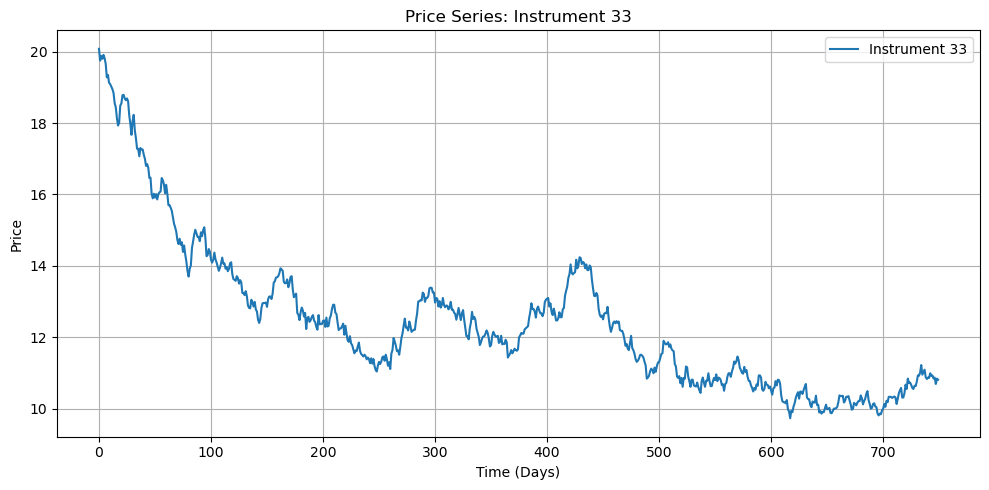

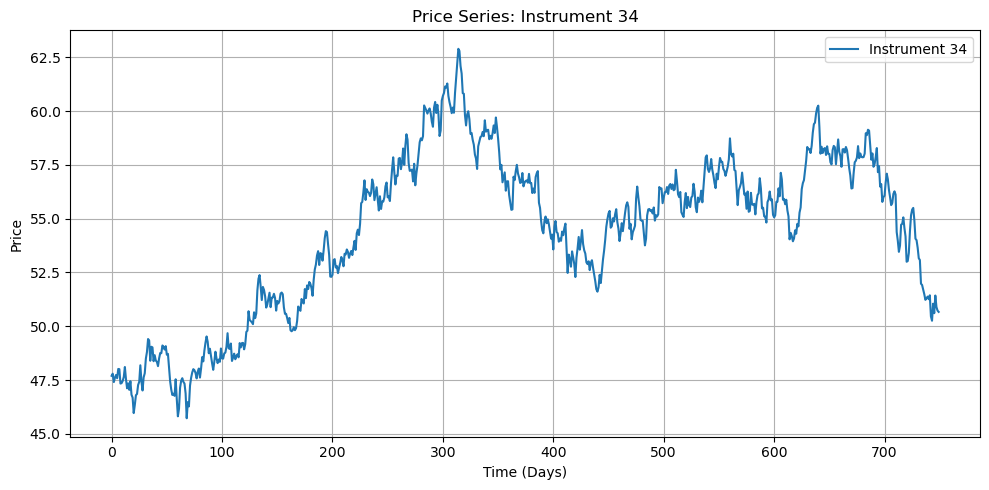

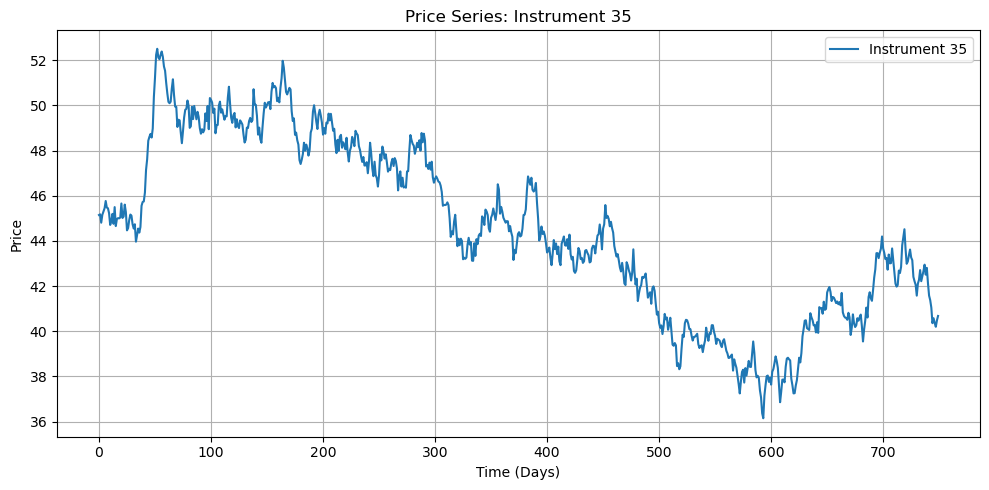

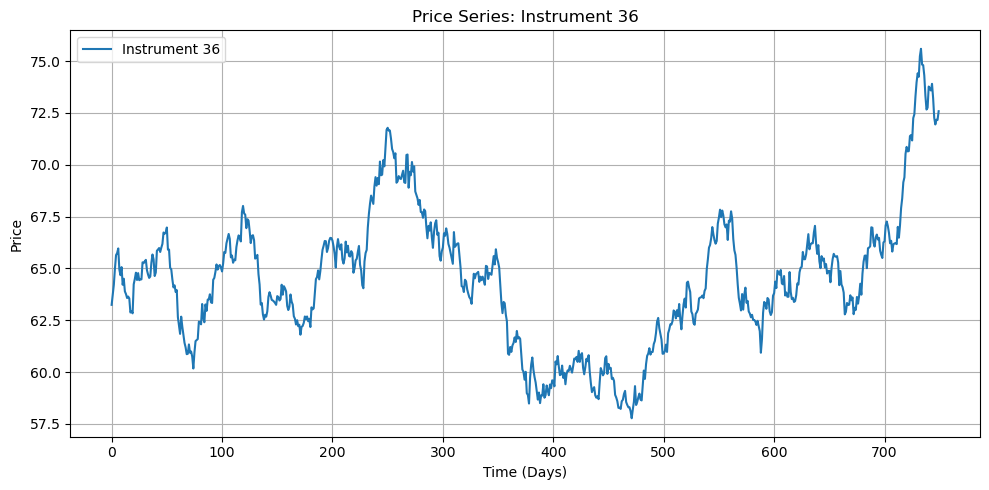

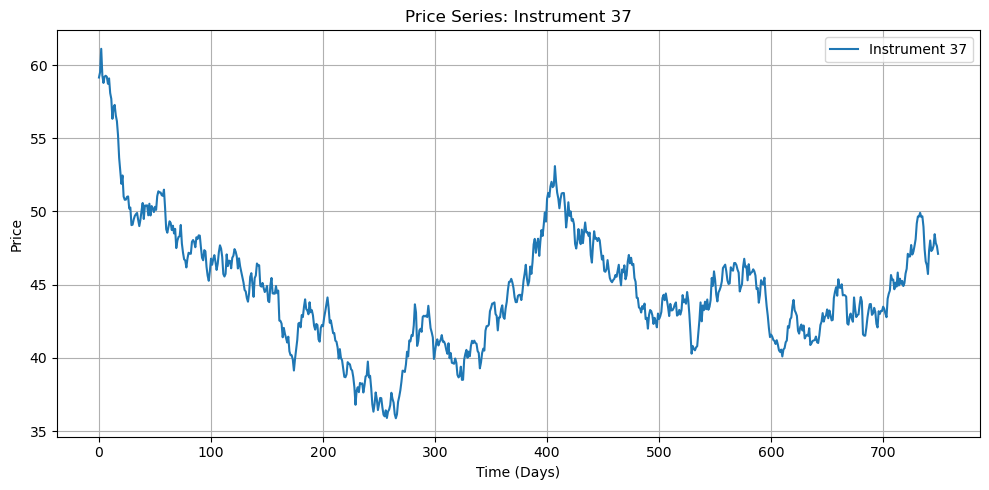

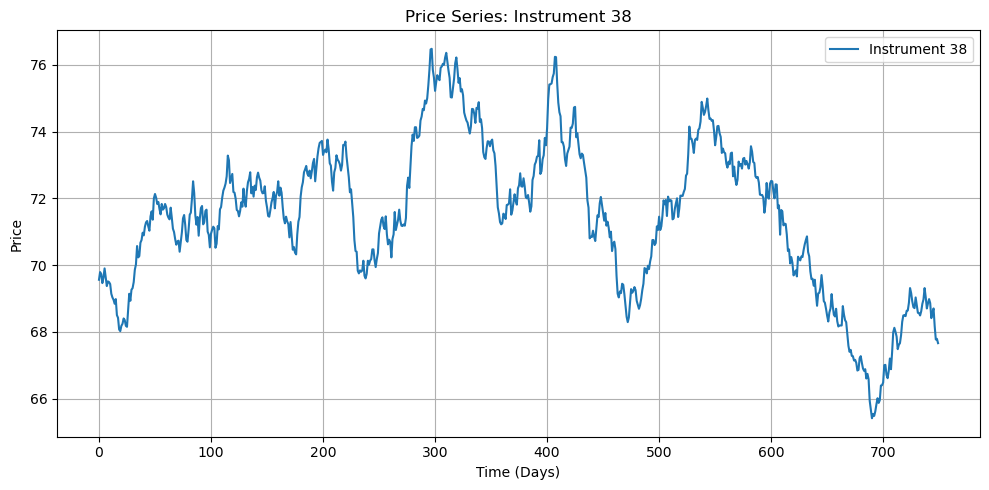

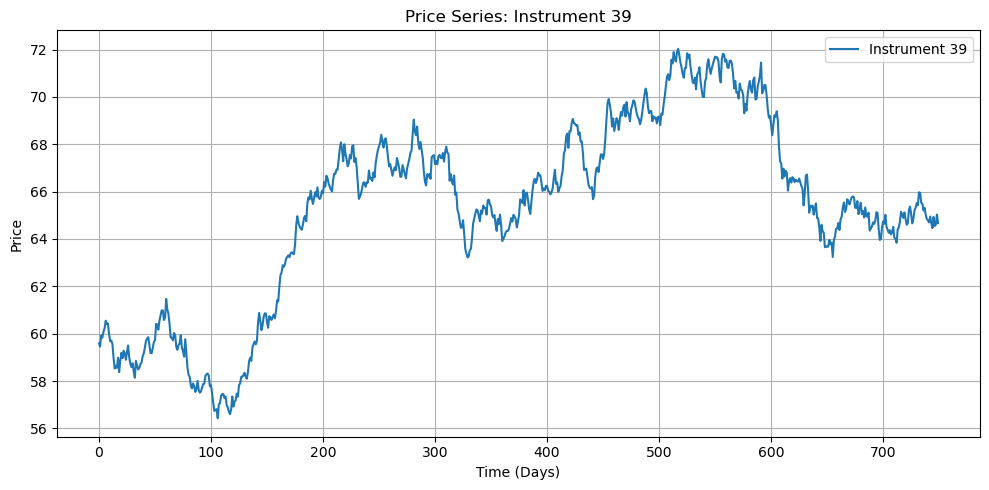

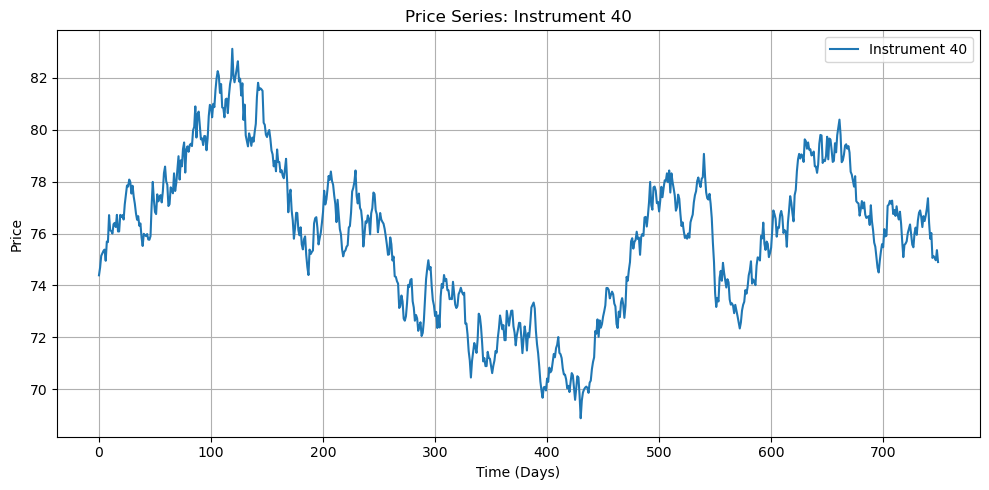

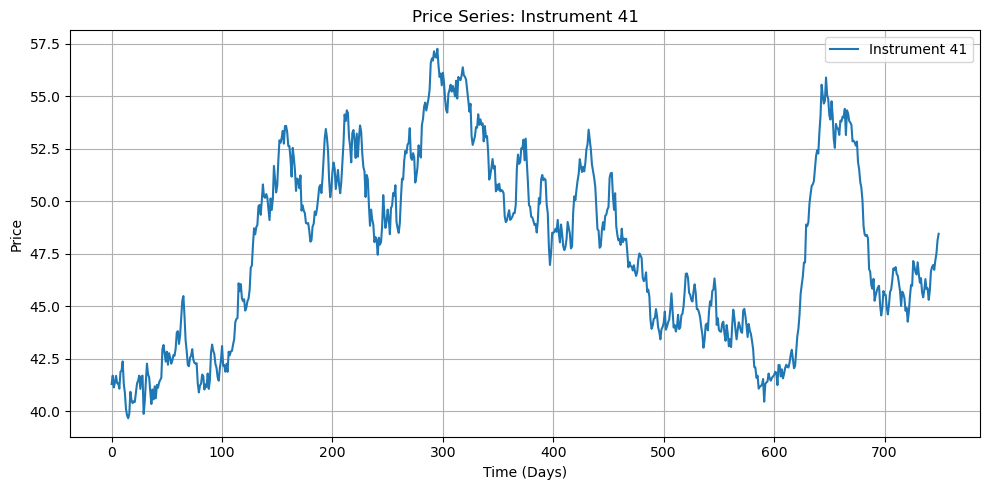

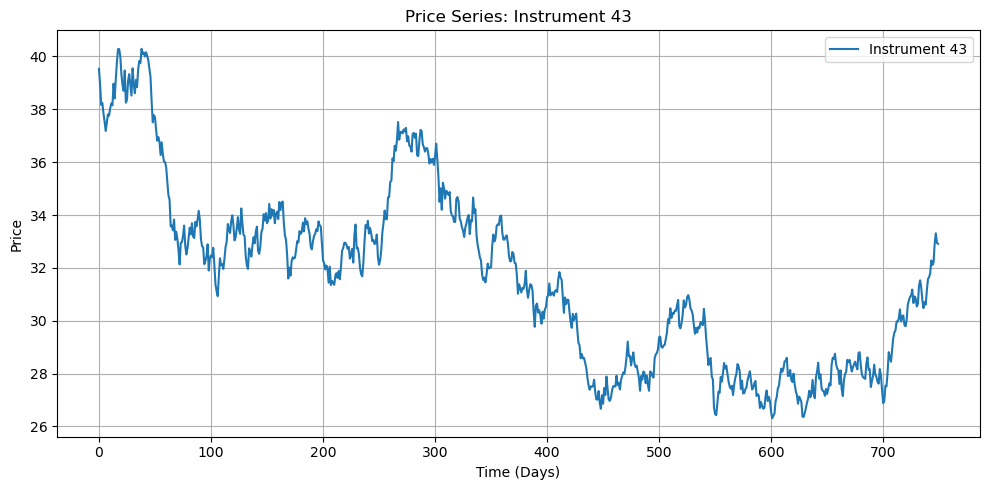

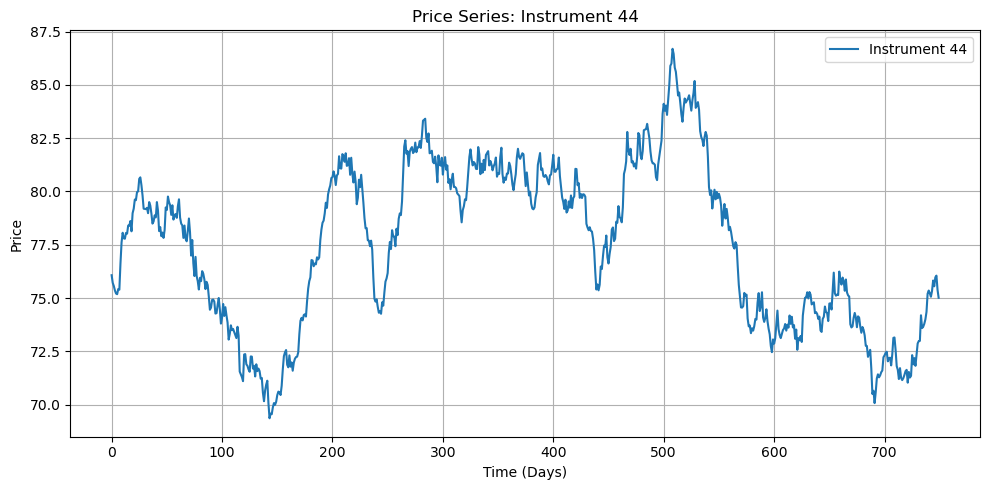

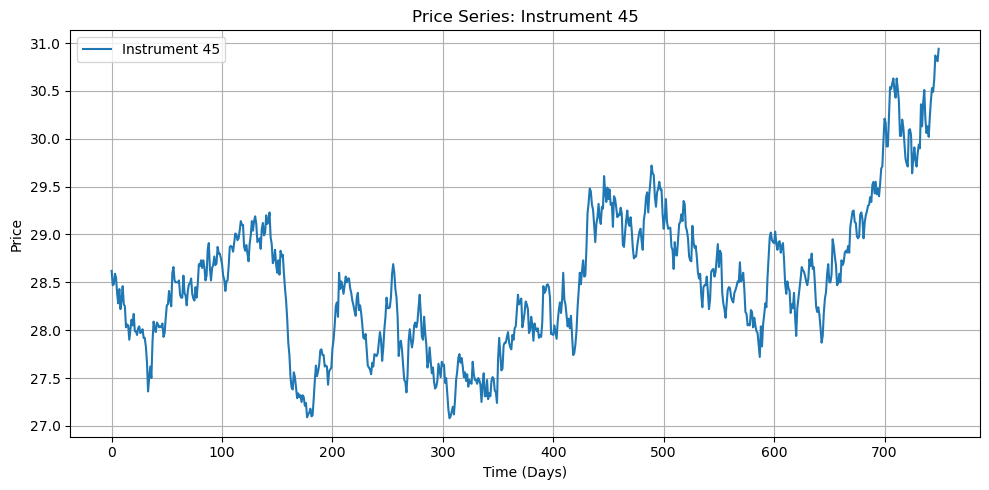

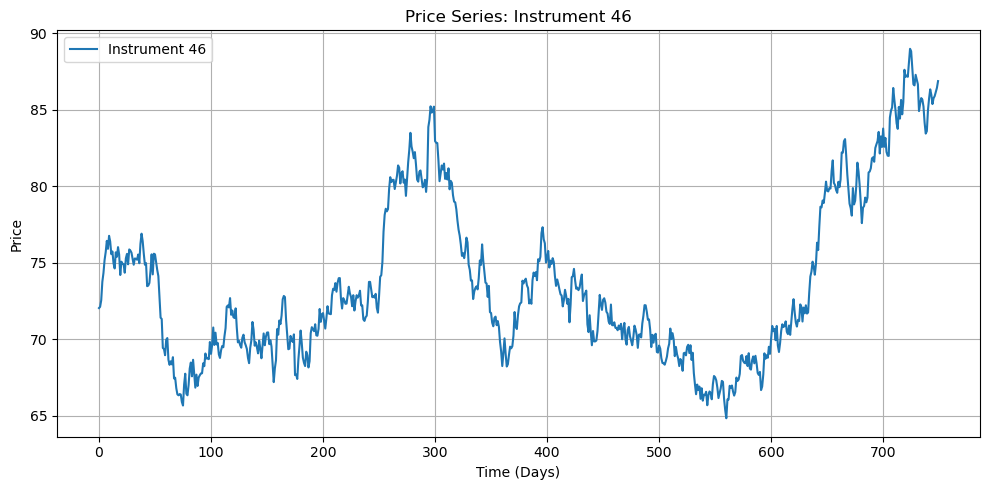

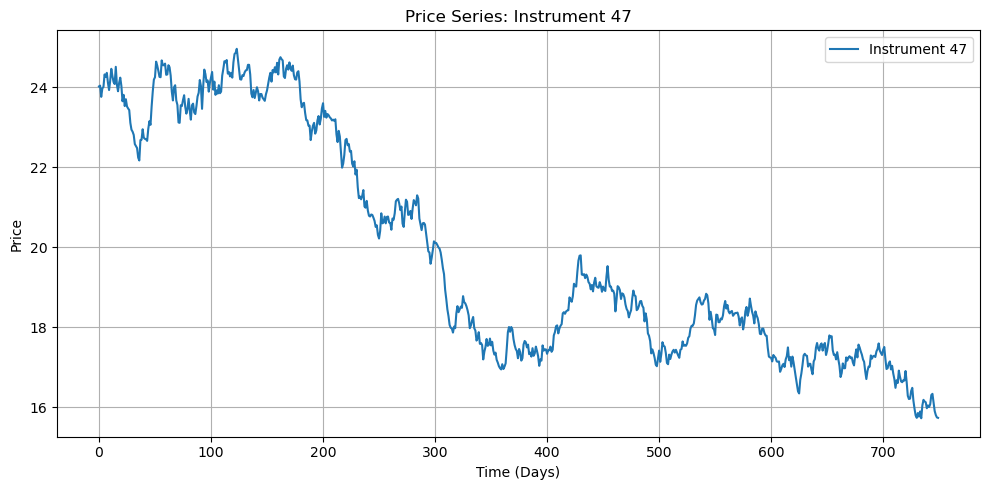

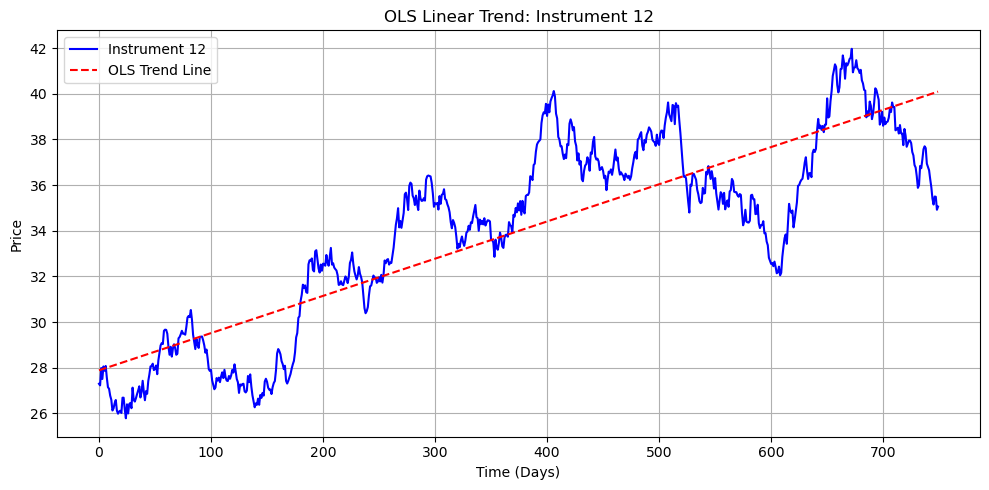

In [5]:
def get_unused_instruments(stationary_pairs, prices):
    used = set()
    for i, j, corr in stationary_pairs:
        used.add(i)
        used.add(j)
    n = prices.shape[0]
    print(n)
    unused = []
    for i in range(n):
        if i not in used:
            unused.append(i)
    return unused

unused_instruments = get_unused_instruments(coint_pairs, prices)

def plot_prices(unused_instruments):
    for i in unused_instruments:
        plt.figure(figsize=(10, 5))
        plt.plot(prices[i], label=f"Instrument {i}")
        plt.title(f"Price Series: Instrument {i}")
        plt.xlabel("Time (Days)")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
plot_prices(unused_instruments)


# inst 12
instrument_id = 12
price_series = prices[instrument_id]
days = np.arange(len(price_series))

X = sm.add_constant(days)
model = sm.OLS(price_series, X).fit()
trend_line = model.predict(X)

plt.figure(figsize=(10, 5))
plt.plot(days, price_series, label=f"Instrument {instrument_id}", color='blue')
plt.plot(days, trend_line, label="OLS Trend Line", linestyle='--', color='red')
plt.title(f"OLS Linear Trend: Instrument {instrument_id}")
plt.xlabel("Time (Days)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()